In [1]:
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
!nvidia-smi

Sun Feb 18 20:46:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   35C    P8              19W / 215W |    316MiB /  8192MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_dir = '../data/physionet/fold4/'

cuda


In [6]:
sr = 16000

x_train = np.load(f'{data_dir}heartsound.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}heartsound.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}heartsound.labels_binary.test.npy', allow_pickle=True)

In [8]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=False, 
                              batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, 
                             batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [9]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [12]:
from IConNet.nn.model import M13
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m13.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M13(config=model_config,
           n_input=1, n_output=2)
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M13
description: FirConv with fftconv
fe:
  n_block: 2
  n_channel:
  - 128
  - 32
  kernel_size:
  - 511
  - 127
  stride:
  - 8
  - 2
  window_k:
  - 2
  - 9
  residual_connection_type: stack
  pooling: mean
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer)

In [13]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [14]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    # print(f'Mem before training: {torch.cuda.memory_allocated()}')
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [15]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                        | 0.002061855670103093/10 [00:00<1:02:57, 377.82s/it]

Train Epoch: 1 [0/11481 (0%)]	Loss: 0.407902
Mem before-during-after: 633344 4366444544 33845760


  1%|▋                                                                          | 0.08453608247422686/10 [00:17<34:30, 208.79s/it]

Train Epoch: 1 [1280/11481 (11%)]	Loss: 0.282500
Mem before-during-after: 33698304 4376186880 33812992


  2%|█▎                                                                         | 0.16701030927835056/10 [00:34<34:15, 209.03s/it]

Train Epoch: 1 [2560/11481 (22%)]	Loss: 0.665909
Mem before-during-after: 33698304 4376186880 33812992


  2%|█▊                                                                         | 0.24948453608247398/10 [00:51<34:18, 211.09s/it]

Train Epoch: 1 [3840/11481 (34%)]	Loss: 0.163518
Mem before-during-after: 33698304 4376186880 33812992


  3%|██▌                                                                         | 0.3319587628865974/10 [01:09<34:42, 215.38s/it]

Train Epoch: 1 [5120/11481 (45%)]	Loss: 0.548327
Mem before-during-after: 33698304 4376186880 33812992


  4%|███                                                                        | 0.41443298969072084/10 [01:26<38:34, 241.46s/it]

Train Epoch: 1 [6400/11481 (56%)]	Loss: 0.522410
Mem before-during-after: 33698304 4376186880 33812992


  5%|███▋                                                                       | 0.49690721649484426/10 [01:44<33:37, 212.35s/it]

Train Epoch: 1 [7680/11481 (67%)]	Loss: 0.562714
Mem before-during-after: 33698304 4376186880 33812992


  6%|████▍                                                                       | 0.5793814432989677/10 [02:02<34:16, 218.32s/it]

Train Epoch: 1 [8960/11481 (78%)]	Loss: 0.309714
Mem before-during-after: 33698304 4376186880 33812992


  7%|█████                                                                       | 0.6618556701030911/10 [02:19<32:47, 210.70s/it]

Train Epoch: 1 [10240/11481 (89%)]	Loss: 0.722750
Mem before-during-after: 33698304 4376186880 33812992


 10%|███████▌                                                                    | 0.9999999999999971/10 [03:02<15:39, 104.38s/it]


Test Epoch: 1	Accuracy: 3094/4064 (76%)



 10%|███████▌                                                                    | 1.0020618556701002/10 [03:02<19:49, 132.20s/it]

Train Epoch: 2 [0/11481 (0%)]	Loss: 0.268297
Mem before-during-after: 33658368 4377006592 33665536


 11%|████████▏                                                                   | 1.0845360824742236/10 [03:19<31:22, 211.10s/it]

Train Epoch: 2 [1280/11481 (11%)]	Loss: 0.330110
Mem before-during-after: 33665536 4377096704 33665536


 12%|████████▉                                                                    | 1.167010309278347/10 [03:36<30:29, 207.17s/it]

Train Epoch: 2 [2560/11481 (22%)]	Loss: 0.540267
Mem before-during-after: 33665536 4377096704 33665536


 12%|█████████▍                                                                  | 1.2494845360824705/10 [03:52<30:07, 206.53s/it]

Train Epoch: 2 [3840/11481 (34%)]	Loss: 0.172106
Mem before-during-after: 33665536 4377096704 33665536


 13%|██████████                                                                  | 1.3319587628865939/10 [04:09<29:49, 206.42s/it]

Train Epoch: 2 [5120/11481 (45%)]	Loss: 0.965617
Mem before-during-after: 33665536 4377096704 33665536


 14%|██████████▋                                                                 | 1.4144329896907173/10 [04:26<30:02, 209.93s/it]

Train Epoch: 2 [6400/11481 (56%)]	Loss: 0.273002
Mem before-during-after: 33665536 4377096704 33665536


 15%|███████████▍                                                                | 1.4969072164948407/10 [04:43<29:34, 208.69s/it]

Train Epoch: 2 [7680/11481 (67%)]	Loss: 0.400831
Mem before-during-after: 33665536 4377096704 33665536


 16%|████████████                                                                | 1.5793814432989641/10 [05:00<29:40, 211.43s/it]

Train Epoch: 2 [8960/11481 (78%)]	Loss: 0.264163
Mem before-during-after: 33665536 4377096704 33665536


 17%|████████████▋                                                               | 1.6618556701030875/10 [05:16<28:32, 205.34s/it]

Train Epoch: 2 [10240/11481 (89%)]	Loss: 0.607640
Mem before-during-after: 33665536 4377096704 33665536


 20%|███████████████▏                                                            | 1.9999999999999936/10 [05:59<13:37, 102.20s/it]


Test Epoch: 2	Accuracy: 3343/4064 (82%)



 20%|███████████████▍                                                             | 2.002061855670097/10 [05:59<17:15, 129.42s/it]

Train Epoch: 3 [0/11481 (0%)]	Loss: 0.136114
Mem before-during-after: 33658368 4377022976 33665536


 21%|███████████████▊                                                            | 2.0845360824742203/10 [06:16<27:22, 207.50s/it]

Train Epoch: 3 [1280/11481 (11%)]	Loss: 0.010581
Mem before-during-after: 33681920 4376540160 33681920


 22%|████████████████▍                                                           | 2.1670103092783437/10 [06:33<27:04, 207.39s/it]

Train Epoch: 3 [2560/11481 (22%)]	Loss: 0.431223
Mem before-during-after: 33681920 4376540160 33681920


 22%|█████████████████▎                                                           | 2.249484536082467/10 [06:49<26:34, 205.76s/it]

Train Epoch: 3 [3840/11481 (34%)]	Loss: 0.048061
Mem before-during-after: 33681920 4376540160 33681920


 23%|█████████████████▋                                                          | 2.3319587628865905/10 [07:06<26:49, 209.93s/it]

Train Epoch: 3 [5120/11481 (45%)]	Loss: 0.806554
Mem before-during-after: 33681920 4376540160 33681920


 24%|██████████████████▌                                                          | 2.414432989690714/10 [07:23<26:10, 207.07s/it]

Train Epoch: 3 [6400/11481 (56%)]	Loss: 0.283707
Mem before-during-after: 33681920 4376540160 33681920


 25%|██████████████████▉                                                         | 2.4969072164948374/10 [07:40<26:05, 208.63s/it]

Train Epoch: 3 [7680/11481 (67%)]	Loss: 0.408666
Mem before-during-after: 33681920 4376540160 33681920


 26%|███████████████████▊                                                         | 2.579381443298961/10 [07:56<26:00, 210.28s/it]

Train Epoch: 3 [8960/11481 (78%)]	Loss: 0.177572
Mem before-during-after: 33681920 4376540160 33681920


 27%|████████████████████▍                                                        | 2.661855670103084/10 [08:13<25:08, 205.56s/it]

Train Epoch: 3 [10240/11481 (89%)]	Loss: 0.340132
Mem before-during-after: 33681920 4376540160 33681920


 30%|██████████████████████▊                                                     | 2.9999999999999902/10 [08:55<11:59, 102.76s/it]


Test Epoch: 3	Accuracy: 3302/4064 (81%)



 30%|██████████████████████▊                                                     | 3.0020618556700933/10 [08:56<15:26, 132.47s/it]

Train Epoch: 4 [0/11481 (0%)]	Loss: 0.094212
Mem before-during-after: 33658368 4377088512 34599936


 31%|███████████████████████▍                                                    | 3.0845360824742167/10 [09:12<23:39, 205.29s/it]

Train Epoch: 4 [1280/11481 (11%)]	Loss: 0.216642
Mem before-during-after: 33681920 4376908800 33681920


 32%|████████████████████████▋                                                     | 3.16701030927834/10 [09:29<23:46, 208.76s/it]

Train Epoch: 4 [2560/11481 (22%)]	Loss: 0.412636
Mem before-during-after: 33681920 4376908800 33681920


 32%|████████████████████████▋                                                   | 3.2494845360824636/10 [09:46<23:01, 204.65s/it]

Train Epoch: 4 [3840/11481 (34%)]	Loss: 0.045202
Mem before-during-after: 33681920 4376908800 33681920


 33%|█████████████████████████▋                                                   | 3.331958762886587/10 [10:02<23:19, 209.88s/it]

Train Epoch: 4 [5120/11481 (45%)]	Loss: 0.834037
Mem before-during-after: 33681920 4376908800 33681920


 34%|█████████████████████████▉                                                  | 3.4144329896907104/10 [10:19<22:31, 205.17s/it]

Train Epoch: 4 [6400/11481 (56%)]	Loss: 0.298427
Mem before-during-after: 33681920 4376908800 33681920


 35%|██████████████████████████▉                                                  | 3.496907216494834/10 [10:36<22:33, 208.08s/it]

Train Epoch: 4 [7680/11481 (67%)]	Loss: 0.356180
Mem before-during-after: 33681920 4376908800 33681920


 36%|███████████████████████████▏                                                | 3.5793814432989572/10 [10:52<21:59, 205.53s/it]

Train Epoch: 4 [8960/11481 (78%)]	Loss: 0.142090
Mem before-during-after: 33681920 4376908800 33681920


 37%|███████████████████████████▊                                                | 3.6618556701030807/10 [11:09<21:48, 206.47s/it]

Train Epoch: 4 [10240/11481 (89%)]	Loss: 0.525974
Mem before-during-after: 33681920 4376908800 33681920


 40%|██████████████████████████████▍                                             | 3.9999999999999867/10 [11:52<10:14, 102.44s/it]


Test Epoch: 4	Accuracy: 3420/4064 (84%)



 40%|███████████████████████████████▏                                              | 4.00206185567009/10 [11:52<12:56, 129.44s/it]

Train Epoch: 5 [0/11481 (0%)]	Loss: 0.039522
Mem before-during-after: 33658368 4377088512 34599936


 41%|███████████████████████████████▍                                             | 4.084536082474213/10 [12:09<20:22, 206.58s/it]

Train Epoch: 5 [1280/11481 (11%)]	Loss: 0.053281
Mem before-during-after: 33681920 4376908800 33681920


 42%|████████████████████████████████                                             | 4.167010309278337/10 [12:25<20:33, 211.49s/it]

Train Epoch: 5 [2560/11481 (22%)]	Loss: 0.414001
Mem before-during-after: 33681920 4376908800 33681920


 42%|█████████████████████████████████▏                                            | 4.24948453608246/10 [12:42<20:09, 210.39s/it]

Train Epoch: 5 [3840/11481 (34%)]	Loss: 0.048895
Mem before-during-after: 33681920 4376908800 33681920


 43%|█████████████████████████████████▎                                           | 4.331958762886583/10 [13:00<20:50, 220.70s/it]

Train Epoch: 5 [5120/11481 (45%)]	Loss: 0.815470
Mem before-during-after: 33681920 4376908800 33681920


 44%|█████████████████████████████████▉                                           | 4.414432989690707/10 [13:18<20:32, 220.67s/it]

Train Epoch: 5 [6400/11481 (56%)]	Loss: 0.300061
Mem before-during-after: 33681920 4376908800 33681920


 45%|███████████████████████████████████                                           | 4.49690721649483/10 [13:36<19:58, 217.74s/it]

Train Epoch: 5 [7680/11481 (67%)]	Loss: 0.295051
Mem before-during-after: 33681920 4376908800 33681920


 46%|███████████████████████████████████▎                                         | 4.579381443298954/10 [13:54<19:59, 221.30s/it]

Train Epoch: 5 [8960/11481 (78%)]	Loss: 0.135581
Mem before-during-after: 33681920 4376908800 33681920


 47%|███████████████████████████████████▉                                         | 4.661855670103077/10 [14:11<19:52, 223.31s/it]

Train Epoch: 5 [10240/11481 (89%)]	Loss: 0.281540
Mem before-during-after: 33681920 4376908800 33681920


 50%|██████████████████████████████████████▍                                      | 4.999999999999983/10 [15:00<10:16, 123.22s/it]


Test Epoch: 5	Accuracy: 3368/4064 (82%)



 50%|██████████████████████████████████████▌                                      | 5.002061855670086/10 [15:00<12:25, 149.26s/it]

Train Epoch: 6 [0/11481 (0%)]	Loss: 0.087077
Mem before-during-after: 33658368 4377088512 34599936


 51%|███████████████████████████████████████▋                                      | 5.08453608247421/10 [15:18<18:14, 222.68s/it]

Train Epoch: 6 [1280/11481 (11%)]	Loss: 0.060529
Mem before-during-after: 33681920 4376908800 33681920


 52%|███████████████████████████████████████▊                                     | 5.167010309278333/10 [15:36<17:52, 221.86s/it]

Train Epoch: 6 [2560/11481 (22%)]	Loss: 0.416714
Mem before-during-after: 33681920 4376908800 33681920


 52%|███████████████████████████████████████▉                                    | 5.2494845360824565/10 [15:54<17:55, 226.33s/it]

Train Epoch: 6 [3840/11481 (34%)]	Loss: 0.056752
Mem before-during-after: 33681920 4376908800 33681920


 53%|█████████████████████████████████████████▌                                    | 5.33195876288658/10 [16:11<16:21, 210.27s/it]

Train Epoch: 6 [5120/11481 (45%)]	Loss: 0.768108
Mem before-during-after: 33681920 4376908800 33681920


 54%|█████████████████████████████████████████▋                                   | 5.414432989690703/10 [16:28<16:01, 209.65s/it]

Train Epoch: 6 [6400/11481 (56%)]	Loss: 0.247018
Mem before-during-after: 33681920 4376908800 33681920


 55%|██████████████████████████████████████████▎                                  | 5.496907216494827/10 [16:45<15:49, 210.77s/it]

Train Epoch: 6 [7680/11481 (67%)]	Loss: 0.317877
Mem before-during-after: 33681920 4376908800 33681920


 56%|███████████████████████████████████████████▌                                  | 5.57938144329895/10 [17:02<15:15, 207.10s/it]

Train Epoch: 6 [8960/11481 (78%)]	Loss: 0.129654
Mem before-during-after: 33681920 4376908800 33681920


 57%|███████████████████████████████████████████▌                                 | 5.661855670103074/10 [17:19<15:29, 214.17s/it]

Train Epoch: 6 [10240/11481 (89%)]	Loss: 0.488238
Mem before-during-after: 33681920 4376908800 33681920


 60%|██████████████████████████████████████████████▊                               | 5.99999999999998/10 [18:03<07:05, 106.38s/it]


Test Epoch: 6	Accuracy: 3469/4064 (85%)



 60%|██████████████████████████████████████████████▏                              | 6.002061855670083/10 [18:03<08:49, 132.35s/it]

Train Epoch: 7 [0/11481 (0%)]	Loss: 0.059856
Mem before-during-after: 33658368 4377088512 34599936


 61%|██████████████████████████████████████████████▊                              | 6.084536082474206/10 [18:20<13:42, 209.95s/it]

Train Epoch: 7 [1280/11481 (11%)]	Loss: 0.010174
Mem before-during-after: 33681920 4376908800 33681920


 62%|██████████████████████████████████████████████▊                             | 6.1670103092783295/10 [18:37<13:48, 216.15s/it]

Train Epoch: 7 [2560/11481 (22%)]	Loss: 0.421140
Mem before-during-after: 33681920 4376908800 33681920


 62%|████████████████████████████████████████████████                             | 6.249484536082453/10 [18:54<13:15, 212.01s/it]

Train Epoch: 7 [3840/11481 (34%)]	Loss: 0.129523
Mem before-during-after: 33681920 4376908800 33681920


 63%|████████████████████████████████████████████████▊                            | 6.331958762886576/10 [19:11<12:58, 212.17s/it]

Train Epoch: 7 [5120/11481 (45%)]	Loss: 0.745994
Mem before-during-after: 33681920 4376908800 33681920


 64%|██████████████████████████████████████████████████▋                            | 6.4144329896907/10 [19:28<12:18, 205.83s/it]

Train Epoch: 7 [6400/11481 (56%)]	Loss: 0.265230
Mem before-during-after: 33681920 4376908800 33681920


 65%|██████████████████████████████████████████████████                           | 6.496907216494823/10 [19:45<12:08, 207.87s/it]

Train Epoch: 7 [7680/11481 (67%)]	Loss: 0.335921
Mem before-during-after: 33681920 4376908800 33681920


 66%|██████████████████████████████████████████████████▋                          | 6.579381443298947/10 [20:02<11:52, 208.41s/it]

Train Epoch: 7 [8960/11481 (78%)]	Loss: 0.133877
Mem before-during-after: 33681920 4376908800 33681920


 67%|███████████████████████████████████████████████████▉                          | 6.66185567010307/10 [20:19<12:16, 220.53s/it]

Train Epoch: 7 [10240/11481 (89%)]	Loss: 0.449278
Mem before-during-after: 33681920 4376908800 33681920


 70%|█████████████████████████████████████████████████████▉                       | 6.999999999999976/10 [21:03<05:30, 110.16s/it]


Test Epoch: 7	Accuracy: 3471/4064 (85%)



 70%|█████████████████████████████████████████████████████▉                       | 7.002061855670079/10 [21:03<06:46, 135.69s/it]

Train Epoch: 8 [0/11481 (0%)]	Loss: 0.046902
Mem before-during-after: 33658368 4377088512 34599936


 71%|█████████████████████████████████████████████████████▊                      | 7.0845360824742025/10 [21:21<09:59, 205.76s/it]

Train Epoch: 8 [1280/11481 (11%)]	Loss: 0.016743
Mem before-during-after: 33681920 4376908800 33681920


 72%|███████████████████████████████████████████████████████▏                     | 7.167010309278326/10 [21:38<09:55, 210.20s/it]

Train Epoch: 8 [2560/11481 (22%)]	Loss: 0.457382
Mem before-during-after: 33681920 4376908800 33681920


 72%|███████████████████████████████████████████████████████▊                     | 7.249484536082449/10 [21:57<11:26, 249.72s/it]

Train Epoch: 8 [3840/11481 (34%)]	Loss: 0.112119
Mem before-during-after: 33681920 4376908800 33681920


 73%|████████████████████████████████████████████████████████▍                    | 7.331958762886573/10 [22:16<11:43, 263.86s/it]

Train Epoch: 8 [5120/11481 (45%)]	Loss: 0.823786
Mem before-during-after: 33681920 4376908800 33681920


 74%|█████████████████████████████████████████████████████████                    | 7.414432989690696/10 [22:35<09:17, 215.43s/it]

Train Epoch: 8 [6400/11481 (56%)]	Loss: 0.276975
Mem before-during-after: 33681920 4376908800 33681920


 75%|██████████████████████████████████████████████████████████▍                   | 7.49690721649482/10 [22:52<08:38, 206.95s/it]

Train Epoch: 8 [7680/11481 (67%)]	Loss: 0.313024
Mem before-during-after: 33681920 4376908800 33681920


 76%|██████████████████████████████████████████████████████████▎                  | 7.579381443298943/10 [23:09<08:21, 207.06s/it]

Train Epoch: 8 [8960/11481 (78%)]	Loss: 0.151557
Mem before-during-after: 33681920 4376908800 33681920


 77%|██████████████████████████████████████████████████████████▏                 | 7.6618556701030665/10 [23:28<09:25, 241.72s/it]

Train Epoch: 8 [10240/11481 (89%)]	Loss: 0.370443
Mem before-during-after: 33681920 4376908800 33681920


 80%|████████████████████████████████████████████████████████████▊               | 7.9999999999999725/10 [24:15<03:32, 106.33s/it]


Test Epoch: 8	Accuracy: 3474/4064 (85%)



 80%|█████████████████████████████████████████████████████████████▌               | 8.002061855670076/10 [24:15<04:24, 132.31s/it]

Train Epoch: 9 [0/11481 (0%)]	Loss: 0.050993
Mem before-during-after: 33658368 4377088512 34599936


 81%|███████████████████████████████████████████████████████████████▊               | 8.0845360824742/10 [24:32<06:35, 206.22s/it]

Train Epoch: 9 [1280/11481 (11%)]	Loss: 0.019283
Mem before-during-after: 33681920 4376908800 33681920


 82%|██████████████████████████████████████████████████████████████▉              | 8.167010309278323/10 [24:49<06:35, 215.53s/it]

Train Epoch: 9 [2560/11481 (22%)]	Loss: 0.399853
Mem before-during-after: 33681920 4376908800 33681920


 82%|███████████████████████████████████████████████████████████████▌             | 8.249484536082447/10 [25:06<06:04, 208.32s/it]

Train Epoch: 9 [3840/11481 (34%)]	Loss: 0.080518
Mem before-during-after: 33681920 4376908800 33681920


 83%|████████████████████████████████████████████████████████████████▉             | 8.33195876288657/10 [25:23<06:05, 218.84s/it]

Train Epoch: 9 [5120/11481 (45%)]	Loss: 0.804240
Mem before-during-after: 33681920 4376908800 33681920


 84%|████████████████████████████████████████████████████████████████▊            | 8.414432989690694/10 [25:40<05:48, 219.78s/it]

Train Epoch: 9 [6400/11481 (56%)]	Loss: 0.286353
Mem before-during-after: 33681920 4376908800 33681920


 85%|█████████████████████████████████████████████████████████████████▍           | 8.496907216494817/10 [25:57<05:15, 210.14s/it]

Train Epoch: 9 [7680/11481 (67%)]	Loss: 0.327063
Mem before-during-after: 33681920 4376908800 33681920


 86%|██████████████████████████████████████████████████████████████████▉           | 8.57938144329894/10 [26:14<04:55, 207.79s/it]

Train Epoch: 9 [8960/11481 (78%)]	Loss: 0.150038
Mem before-during-after: 33681920 4376908800 33681920


 87%|██████████████████████████████████████████████████████████████████▋          | 8.661855670103064/10 [26:31<04:43, 212.16s/it]

Train Epoch: 9 [10240/11481 (89%)]	Loss: 0.354559
Mem before-during-after: 33681920 4376908800 33681920


 90%|██████████████████████████████████████████████████████████████████████▏       | 8.99999999999997/10 [27:15<01:50, 110.49s/it]


Test Epoch: 9	Accuracy: 3495/4064 (85%)



 90%|█████████████████████████████████████████████████████████████████████▎       | 9.002061855670073/10 [27:15<02:14, 134.60s/it]

Train Epoch: 10 [0/11481 (0%)]	Loss: 0.104236
Mem before-during-after: 33658368 4377088512 34599936


 91%|█████████████████████████████████████████████████████████████████████▉       | 9.084536082474196/10 [27:32<03:08, 206.31s/it]

Train Epoch: 10 [1280/11481 (11%)]	Loss: 0.011656
Mem before-during-after: 33681920 4376908800 33681920


 92%|███████████████████████████████████████████████████████████████████████▌      | 9.16701030927832/10 [27:48<03:00, 216.94s/it]

Train Epoch: 10 [2560/11481 (22%)]	Loss: 0.407520
Mem before-during-after: 33681920 4376908800 33681920


 92%|███████████████████████████████████████████████████████████████████████▏     | 9.249484536082443/10 [28:05<02:34, 206.00s/it]

Train Epoch: 10 [3840/11481 (34%)]	Loss: 0.106888
Mem before-during-after: 33681920 4376908800 33681920


 93%|███████████████████████████████████████████████████████████████████████▊     | 9.331958762886567/10 [28:22<02:17, 205.56s/it]

Train Epoch: 10 [5120/11481 (45%)]	Loss: 0.781785
Mem before-during-after: 33681920 4376908800 33681920


 94%|█████████████████████████████████████████████████████████████████████████▍    | 9.41443298969069/10 [28:38<02:00, 205.98s/it]

Train Epoch: 10 [6400/11481 (56%)]	Loss: 0.320660
Mem before-during-after: 33681920 4376908800 33681920


 95%|█████████████████████████████████████████████████████████████████████████▏   | 9.496907216494813/10 [28:55<01:45, 208.76s/it]

Train Epoch: 10 [7680/11481 (67%)]	Loss: 0.347619
Mem before-during-after: 33681920 4376908800 33681920


 96%|█████████████████████████████████████████████████████████████████████████▊   | 9.579381443298937/10 [29:12<01:26, 204.78s/it]

Train Epoch: 10 [8960/11481 (78%)]	Loss: 0.152014
Mem before-during-after: 33681920 4376908800 33681920


 97%|███████████████████████████████████████████████████████████████████████████▎  | 9.66185567010306/10 [29:29<01:14, 219.51s/it]

Train Epoch: 10 [10240/11481 (89%)]	Loss: 0.378001
Mem before-during-after: 33681920 4376908800 33681920


100%|████████████████████████████████████████████████████████████████████████████▉| 9.999999999999966/10 [30:12<00:00, 181.29s/it]


Test Epoch: 10	Accuracy: 3496/4064 (85%)



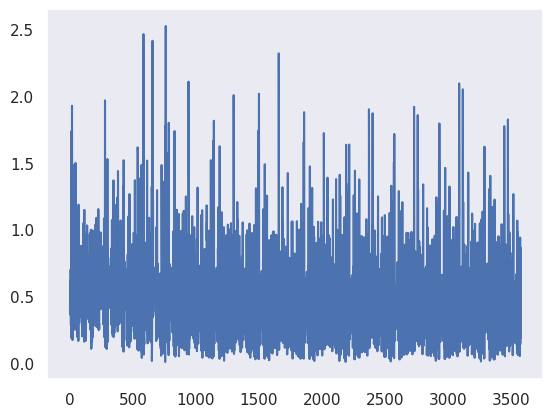

In [16]:
plt.plot(train_losses)

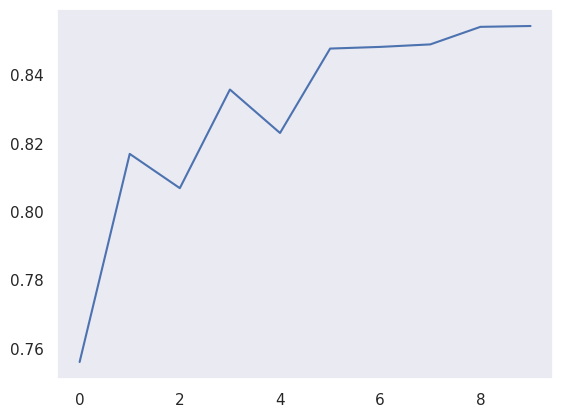

In [17]:
plt.plot(test_accuracy)

In [18]:
model_path = '../physio16k_fold4_m13_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [19]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from torchmetrics.wrappers import ClasswiseWrapper
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [20]:
metrics, confusion_matrix = report_metrics(model)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 3498/4064 (0.8607)
{'acc_detail': tensor([0.6072, 0.9402], device='cuda:0'),
 'acc_unweighted': tensor(0.7737, device='cuda:0'),
 'acc_weighted': tensor(0.8607, device='cuda:0'),
 'f1s': tensor(0.7934, device='cuda:0'),
 'f1s_detail': tensor([0.6755, 0.9113], device='cuda:0'),
 'precision_detail': tensor([0.7610, 0.8842], device='cuda:0'),
 'recall_detail': tensor([0.6072, 0.9402], device='cuda:0'),
 'rocauc': tensor([0.8663, 0.8663], device='cuda:0'),
 'uar': tensor(0.7737, device='cuda:0'),
 'wap': tensor(0.8548, device='cuda:0')}


tensor([[ 589,  381],
        [ 185, 2909]], device='cuda:0')

In [21]:
layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0036],
        [0.0075],
        [0.0117],
        [0.0162],
        [0.0211],
        [0.0264],
        [0.0322],
        [0.0384],
        [0.0451],
        [0.0524],
        [0.0603],
        [0.0688],
        [0.0780],
        [0.0880],
        [0.0988],
        [0.1105],
        [0.1231],
        [0.1368],
        [0.1516],
        [0.1676],
        [0.1849],
        [0.2036],
        [0.2239],
        [0.2458],
        [0.2696],
        [0.2952],
        [0.3230],
        [0.3531],
        [0.3856],
        [0.4208],
        [0.4588],
        [0.0000],
        [0.0054],
        [0.0111],
        [0.0171],
        [0.0235],
        [0.0303],
        [0.0375],
        [0.0452],
        [0.0534],
        [0.0620],
        [0.0712],
        [0.0809],
        [0.0912],
        [0.1022],
        [0.1138],
        [0.1261],
        [0.1392],
        [0.1531],
        [0.1679],
        [0.1835],
        [0.2002],
       

In [22]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-3.0194e-15],
        [-2.9283e-15],
        [-7.4449e-15],
        [ 1.0736e-16],
        [-6.1602e-16],
        [-3.2509e-17],
        [-6.8276e-17],
        [ 8.1279e-16],
        [ 4.5490e-16],
        [ 1.1257e-15],
        [ 4.2117e-15],
        [-8.5321e-16],
        [ 9.4910e-15],
        [-8.8211e-14],
        [-7.9795e-18],
        [ 4.4135e-15],
        [ 1.0346e-14],
        [ 3.0150e-16],
        [ 3.1964e-17],
        [-1.3876e-17],
        [ 1.4019e-15],
        [ 6.5936e-15],
        [ 2.2006e-16],
        [-1.5152e-17],
        [-2.2663e-15],
        [-8.7695e-15],
        [ 5.6741e-15],
        [ 3.4888e-15],
        [-1.1555e-14],
        [-2.4293e-13],
        [ 2.6817e-17],
        [ 0.0000e+00],
        [-7.8689e-16],
        [-1.6973e-16],
        [ 1.8998e-14],
        [ 5.5288e-13],
        [ 2.2646e-16],
        [-2.0344e-15],
        [-4.4315e-17],
        [-9.6671e-16],
        [ 1.8865e-15],
        [-3.1873e-16],
        [ 1

[None, None, None]

Time domain: Filters' shapes vary by frequency bins


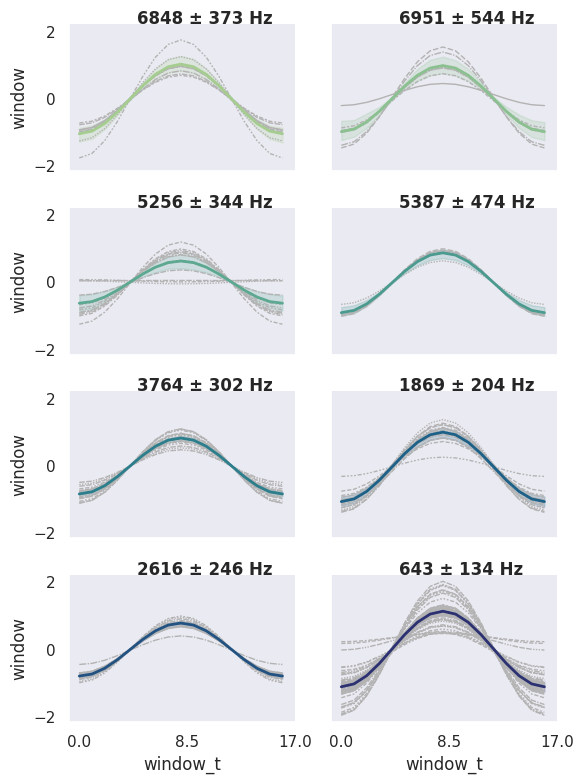

In [23]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


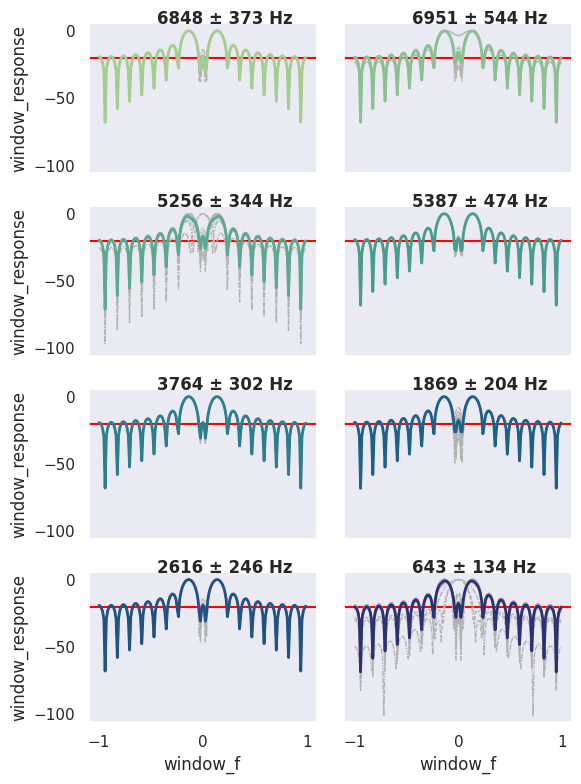

In [24]:
filtviz.visualize_filters(filter_domain='freq')

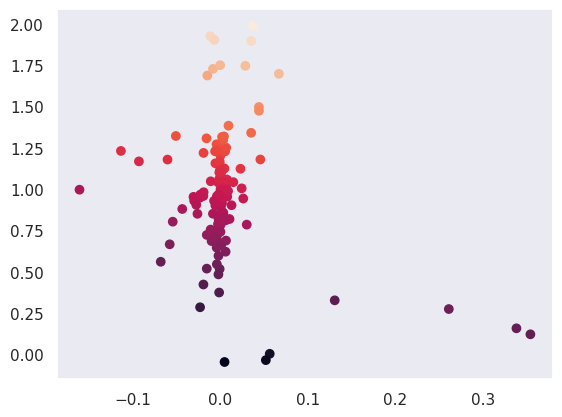

In [25]:
filtviz.visualize_window_params()

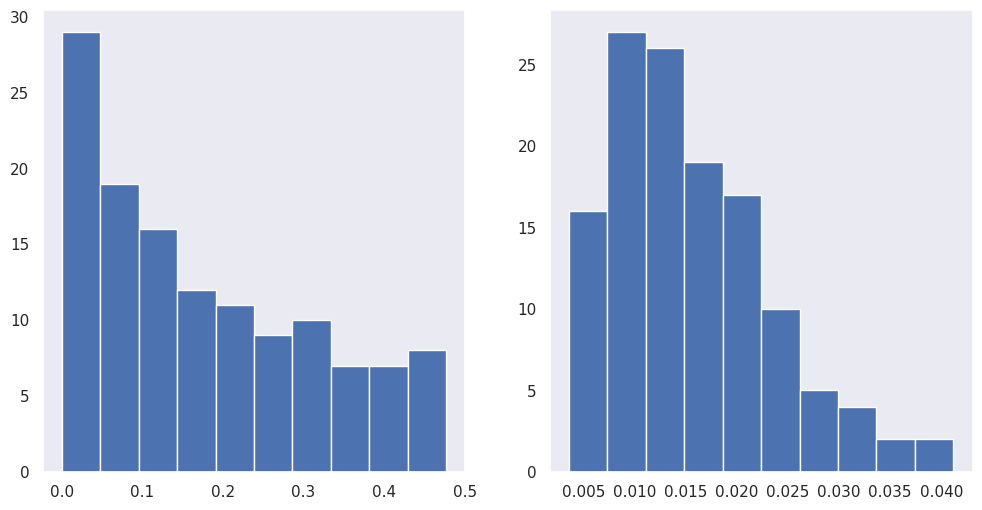

In [26]:
filtviz.visualize_bands()

In [27]:
layer2 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer2)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0384, 0.0384, 0.0384,  ..., 0.0384, 0.0384, 0.0384],
        ...,
        [0.2594, 0.2594, 0.2594,  ..., 0.2594, 0.2594, 0.2594],
        [0.3309, 0.3309, 0.3309,  ..., 0.3309, 0.3309, 0.3309],
        [0.4108, 0.4108, 0.4108,  ..., 0.4108, 0.4108, 0.4108]],
       device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
        [0.0304, 0.0304, 0.0304,  ..., 0.0304, 0.0304, 0.0304],
        ...,
        [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
        [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
        [0.0892, 0.0892, 0.0892,  ..., 0.0892, 0.0892, 0.0892]],
       device='cuda:0', requires_grad=True))
('window_params', Parameter containing

downsample_factor: 8 => new_sample_rate: 2000
Time domain: Filters' shapes vary by frequency bins


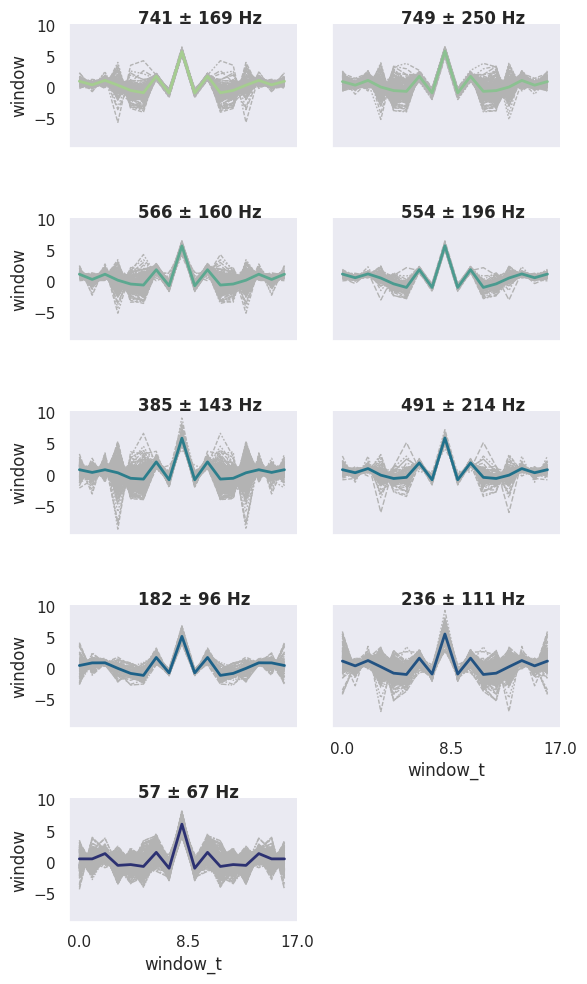

In [28]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


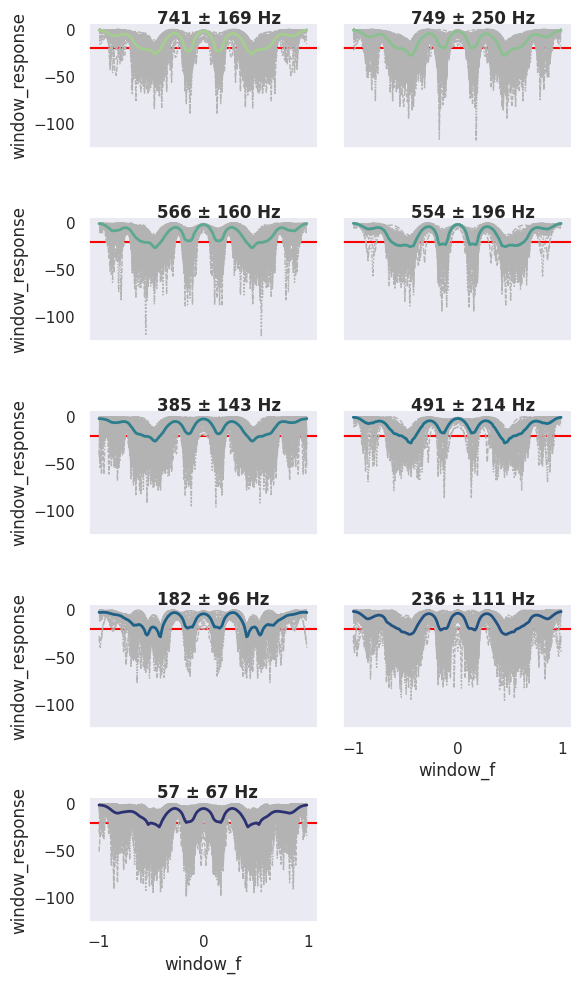

In [29]:
filtviz2.visualize_filters(filter_domain='freq')

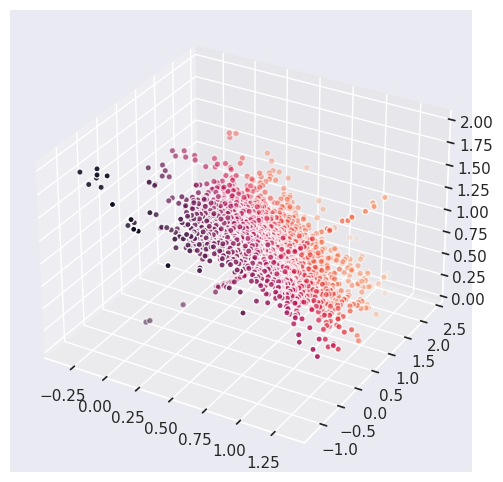

In [30]:
filtviz2.visualize_window_params()

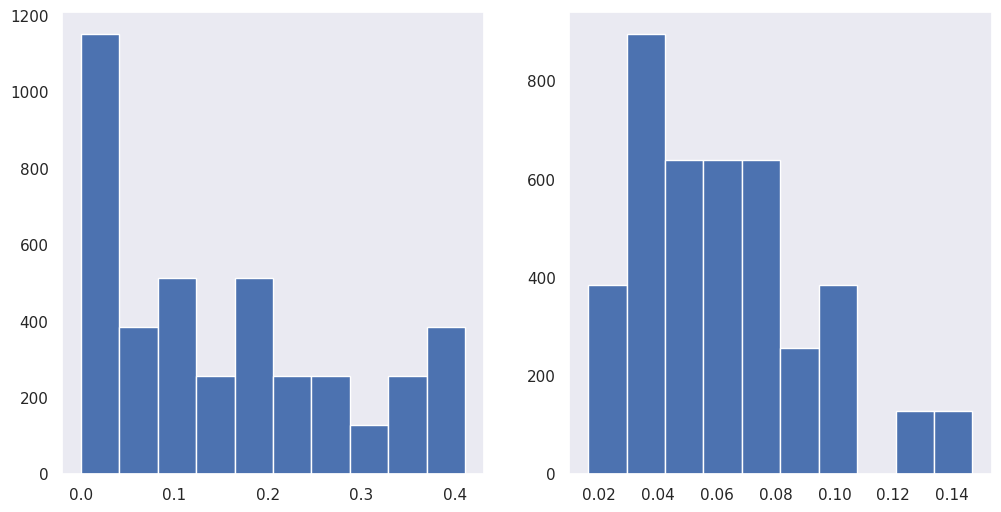

In [31]:
filtviz2.visualize_bands()

In [32]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                        | 0.002061855670103093/50 [00:00<4:15:51, 307.04s/it]

Train Epoch: 11 [0/11481 (0%)]	Loss: 0.035022
Mem before-during-after: 32574976 4375923200 33818112


  0%|                                                                         | 0.08453608247422686/50 [00:18<3:01:14, 217.86s/it]

Train Epoch: 11 [1280/11481 (11%)]	Loss: 0.031619
Mem before-during-after: 33818112 4377249280 33818112


  0%|▏                                                                        | 0.16701030927835056/50 [00:36<3:05:44, 223.65s/it]

Train Epoch: 11 [2560/11481 (22%)]	Loss: 0.469037
Mem before-during-after: 33818112 4377249280 33818112


  0%|▎                                                                        | 0.24948453608247398/50 [00:54<3:02:35, 220.20s/it]

Train Epoch: 11 [3840/11481 (34%)]	Loss: 0.101915
Mem before-during-after: 33818112 4377249280 33818112


  1%|▍                                                                         | 0.3319587628865974/50 [01:11<3:05:02, 223.53s/it]

Train Epoch: 11 [5120/11481 (45%)]	Loss: 0.812607
Mem before-during-after: 33818112 4377249280 33818112


  1%|▌                                                                        | 0.41443298969072084/50 [01:29<3:06:11, 225.29s/it]

Train Epoch: 11 [6400/11481 (56%)]	Loss: 0.216746
Mem before-during-after: 33818112 4377249280 33818112


  1%|▋                                                                        | 0.49690721649484426/50 [01:48<3:06:34, 226.13s/it]

Train Epoch: 11 [7680/11481 (67%)]	Loss: 0.292134
Mem before-during-after: 33818112 4377249280 33818112


  1%|▊                                                                         | 0.5793814432989677/50 [02:07<3:35:02, 261.08s/it]

Train Epoch: 11 [8960/11481 (78%)]	Loss: 0.118647
Mem before-during-after: 33818112 4377249280 33818112


  1%|▉                                                                         | 0.6618556701030911/50 [02:28<3:31:28, 257.17s/it]

Train Epoch: 11 [10240/11481 (89%)]	Loss: 0.191726
Mem before-during-after: 33818112 4377249280 33818112


  2%|█▍                                                                        | 0.9999999999999971/50 [03:16<1:28:59, 108.96s/it]


Test Epoch: 11	Accuracy: 3519/4064 (86%)



  2%|█▍                                                                        | 1.0020618556701002/50 [03:17<2:00:36, 147.68s/it]

Train Epoch: 12 [0/11481 (0%)]	Loss: 0.021959
Mem before-during-after: 33810944 4377175552 33818112


  2%|█▌                                                                        | 1.0845360824742236/50 [03:37<3:26:23, 253.17s/it]

Train Epoch: 12 [1280/11481 (11%)]	Loss: 0.027427
Mem before-during-after: 33834496 4376692736 33834496


  2%|█▊                                                                         | 1.167010309278347/50 [03:58<3:35:45, 265.10s/it]

Train Epoch: 12 [2560/11481 (22%)]	Loss: 0.451688
Mem before-during-after: 33834496 4376692736 33834496


  2%|█▊                                                                        | 1.2494845360824705/50 [04:20<3:33:44, 263.06s/it]

Train Epoch: 12 [3840/11481 (34%)]	Loss: 0.023917
Mem before-during-after: 33834496 4376692736 33834496


  3%|█▉                                                                        | 1.3319587628865939/50 [04:41<3:34:03, 263.90s/it]

Train Epoch: 12 [5120/11481 (45%)]	Loss: 0.780939
Mem before-during-after: 33834496 4376692736 33834496


  3%|██                                                                        | 1.4144329896907173/50 [05:02<3:37:07, 268.14s/it]

Train Epoch: 12 [6400/11481 (56%)]	Loss: 0.230863
Mem before-during-after: 33834496 4376692736 33834496


  3%|██▏                                                                       | 1.4969072164948407/50 [05:23<3:31:06, 261.14s/it]

Train Epoch: 12 [7680/11481 (67%)]	Loss: 0.282637
Mem before-during-after: 33834496 4376692736 33834496


  3%|██▎                                                                       | 1.5793814432989641/50 [05:44<3:32:06, 262.82s/it]

Train Epoch: 12 [8960/11481 (78%)]	Loss: 0.112604
Mem before-during-after: 33834496 4376692736 33834496


  3%|██▍                                                                       | 1.6618556701030875/50 [06:05<3:26:52, 256.78s/it]

Train Epoch: 12 [10240/11481 (89%)]	Loss: 0.174105
Mem before-during-after: 33834496 4376692736 33834496


  4%|██▉                                                                       | 1.9999999999999936/50 [06:54<1:28:40, 110.84s/it]


Test Epoch: 12	Accuracy: 3516/4064 (86%)



  4%|███                                                                        | 2.002061855670097/50 [06:55<1:58:13, 147.79s/it]

Train Epoch: 13 [0/11481 (0%)]	Loss: 0.019431
Mem before-during-after: 33810944 4377241088 34752512


  4%|███                                                                       | 2.0845360824742203/50 [07:15<3:22:49, 253.98s/it]

Train Epoch: 13 [1280/11481 (11%)]	Loss: 0.021911
Mem before-during-after: 33834496 4377061376 33834496


  4%|███▏                                                                      | 2.1670103092783437/50 [07:36<3:25:26, 257.70s/it]

Train Epoch: 13 [2560/11481 (22%)]	Loss: 0.430771
Mem before-during-after: 33834496 4377061376 33834496


  4%|███▎                                                                       | 2.249484536082467/50 [07:57<3:25:15, 257.91s/it]

Train Epoch: 13 [3840/11481 (34%)]	Loss: 0.014778
Mem before-during-after: 33834496 4377061376 33834496


  5%|███▍                                                                      | 2.3319587628865905/50 [08:18<3:21:40, 253.84s/it]

Train Epoch: 13 [5120/11481 (45%)]	Loss: 0.793240
Mem before-during-after: 33834496 4377061376 33834496


  5%|███▌                                                                       | 2.414432989690714/50 [08:38<3:21:39, 254.27s/it]

Train Epoch: 13 [6400/11481 (56%)]	Loss: 0.237884
Mem before-during-after: 33834496 4377061376 33834496


  5%|███▋                                                                      | 2.4969072164948374/50 [08:59<3:20:54, 253.77s/it]

Train Epoch: 13 [7680/11481 (67%)]	Loss: 0.278225
Mem before-during-after: 33834496 4377061376 33834496


  5%|███▊                                                                       | 2.579381443298961/50 [09:17<2:54:47, 221.15s/it]

Train Epoch: 13 [8960/11481 (78%)]	Loss: 0.109425
Mem before-during-after: 33834496 4377061376 33834496


  5%|███▉                                                                       | 2.661855670103084/50 [09:35<2:51:30, 217.38s/it]

Train Epoch: 13 [10240/11481 (89%)]	Loss: 0.172266
Mem before-during-after: 33834496 4377061376 33834496


  6%|████▍                                                                     | 2.9999999999999902/50 [10:20<1:28:12, 112.61s/it]


Test Epoch: 13	Accuracy: 3516/4064 (86%)



  6%|████▍                                                                     | 3.0020618556700933/50 [10:20<1:47:23, 137.10s/it]

Train Epoch: 14 [0/11481 (0%)]	Loss: 0.021460
Mem before-during-after: 33810944 4377241088 34752512


  6%|████▌                                                                     | 3.0845360824742167/50 [10:38<2:49:22, 216.62s/it]

Train Epoch: 14 [1280/11481 (11%)]	Loss: 0.015730
Mem before-during-after: 33834496 4377061376 33834496


  6%|████▊                                                                       | 3.16701030927834/50 [10:55<2:50:04, 217.89s/it]

Train Epoch: 14 [2560/11481 (22%)]	Loss: 0.432570
Mem before-during-after: 33834496 4377061376 33834496


  6%|████▊                                                                     | 3.2494845360824636/50 [11:13<2:49:09, 217.10s/it]

Train Epoch: 14 [3840/11481 (34%)]	Loss: 0.008631
Mem before-during-after: 33834496 4377061376 33834496


  7%|████▉                                                                      | 3.331958762886587/50 [11:30<2:48:35, 216.76s/it]

Train Epoch: 14 [5120/11481 (45%)]	Loss: 0.788309
Mem before-during-after: 33834496 4377061376 33834496


  7%|█████                                                                     | 3.4144329896907104/50 [11:48<2:47:25, 215.64s/it]

Train Epoch: 14 [6400/11481 (56%)]	Loss: 0.169470
Mem before-during-after: 33834496 4377061376 33834496


  7%|█████▏                                                                     | 3.496907216494834/50 [12:06<2:52:51, 223.03s/it]

Train Epoch: 14 [7680/11481 (67%)]	Loss: 0.272439
Mem before-during-after: 33834496 4377061376 33834496


  7%|█████▎                                                                    | 3.5793814432989572/50 [12:23<2:47:37, 216.66s/it]

Train Epoch: 14 [8960/11481 (78%)]	Loss: 0.115399
Mem before-during-after: 33834496 4377061376 33834496


  7%|█████▍                                                                    | 3.6618556701030807/50 [12:41<2:46:47, 215.97s/it]

Train Epoch: 14 [10240/11481 (89%)]	Loss: 0.175706
Mem before-during-after: 33834496 4377061376 33834496


  8%|█████▉                                                                    | 3.9999999999999867/50 [13:26<1:23:30, 108.93s/it]


Test Epoch: 14	Accuracy: 3522/4064 (86%)



  8%|██████                                                                      | 4.00206185567009/50 [13:26<1:45:05, 137.09s/it]

Train Epoch: 15 [0/11481 (0%)]	Loss: 0.025997
Mem before-during-after: 33810944 4377241088 34752512


  8%|██████▏                                                                    | 4.084536082474213/50 [13:44<2:46:05, 217.03s/it]

Train Epoch: 15 [1280/11481 (11%)]	Loss: 0.009810
Mem before-during-after: 33834496 4377061376 33834496


  8%|██████▎                                                                    | 4.167010309278337/50 [14:01<2:45:39, 216.85s/it]

Train Epoch: 15 [2560/11481 (22%)]	Loss: 0.437578
Mem before-during-after: 33834496 4377061376 33834496


  8%|██████▍                                                                     | 4.24948453608246/50 [14:19<2:44:17, 215.47s/it]

Train Epoch: 15 [3840/11481 (34%)]	Loss: 0.006323
Mem before-during-after: 33834496 4377061376 33834496


  9%|██████▍                                                                    | 4.331958762886583/50 [14:36<2:48:52, 221.87s/it]

Train Epoch: 15 [5120/11481 (45%)]	Loss: 0.805696
Mem before-during-after: 33834496 4377061376 33834496


  9%|██████▌                                                                    | 4.414432989690707/50 [14:54<2:51:02, 225.12s/it]

Train Epoch: 15 [6400/11481 (56%)]	Loss: 0.148755
Mem before-during-after: 33834496 4377061376 33834496


  9%|██████▊                                                                     | 4.49690721649483/50 [15:13<3:09:23, 249.72s/it]

Train Epoch: 15 [7680/11481 (67%)]	Loss: 0.279204
Mem before-during-after: 33834496 4377061376 33834496


  9%|██████▊                                                                    | 4.579381443298954/50 [15:32<2:43:37, 216.14s/it]

Train Epoch: 15 [8960/11481 (78%)]	Loss: 0.116434
Mem before-during-after: 33834496 4377061376 33834496


  9%|██████▉                                                                    | 4.661855670103077/50 [15:52<3:12:01, 254.12s/it]

Train Epoch: 15 [10240/11481 (89%)]	Loss: 0.184129
Mem before-during-after: 33834496 4377061376 33834496


 10%|███████▍                                                                   | 4.999999999999983/50 [16:42<1:25:40, 114.24s/it]


Test Epoch: 15	Accuracy: 3520/4064 (86%)



 10%|███████▌                                                                   | 5.002061855670086/50 [16:42<1:53:46, 151.71s/it]

Train Epoch: 16 [0/11481 (0%)]	Loss: 0.031576
Mem before-during-after: 33810944 4377241088 34752512


 10%|███████▋                                                                    | 5.08453608247421/50 [17:03<3:13:51, 258.96s/it]

Train Epoch: 16 [1280/11481 (11%)]	Loss: 0.005802
Mem before-during-after: 33834496 4377061376 33834496


 10%|███████▊                                                                   | 5.167010309278333/50 [17:24<3:07:05, 250.38s/it]

Train Epoch: 16 [2560/11481 (22%)]	Loss: 0.473010
Mem before-during-after: 33834496 4377061376 33834496


 10%|███████▊                                                                  | 5.2494845360824565/50 [17:44<3:09:02, 253.46s/it]

Train Epoch: 16 [3840/11481 (34%)]	Loss: 0.005221
Mem before-during-after: 33834496 4377061376 33834496


 11%|████████                                                                    | 5.33195876288658/50 [18:05<3:09:59, 255.21s/it]

Train Epoch: 16 [5120/11481 (45%)]	Loss: 0.782252
Mem before-during-after: 33834496 4377061376 33834496


 11%|████████                                                                   | 5.414432989690703/50 [18:25<3:08:07, 253.17s/it]

Train Epoch: 16 [6400/11481 (56%)]	Loss: 0.139866
Mem before-during-after: 33834496 4377061376 33834496


 11%|████████▏                                                                  | 5.496907216494827/50 [18:46<3:06:58, 252.07s/it]

Train Epoch: 16 [7680/11481 (67%)]	Loss: 0.276905
Mem before-during-after: 33834496 4377061376 33834496


 11%|████████▍                                                                   | 5.57938144329895/50 [19:06<3:10:42, 257.60s/it]

Train Epoch: 16 [8960/11481 (78%)]	Loss: 0.114876
Mem before-during-after: 33834496 4377061376 33834496


 11%|████████▍                                                                  | 5.661855670103074/50 [19:27<3:04:20, 249.45s/it]

Train Epoch: 16 [10240/11481 (89%)]	Loss: 0.177322
Mem before-during-after: 33834496 4377061376 33834496


 12%|█████████                                                                   | 5.99999999999998/50 [20:16<1:26:05, 117.39s/it]


Test Epoch: 16	Accuracy: 3528/4064 (86%)



 12%|█████████                                                                  | 6.002061855670083/50 [20:16<1:51:35, 152.17s/it]

Train Epoch: 17 [0/11481 (0%)]	Loss: 0.028072
Mem before-during-after: 33810944 4377241088 34752512


 12%|█████████▏                                                                 | 6.084536082474206/50 [20:36<3:06:05, 254.24s/it]

Train Epoch: 17 [1280/11481 (11%)]	Loss: 0.004034
Mem before-during-after: 33834496 4377061376 33834496


 12%|█████████▏                                                                | 6.1670103092783295/50 [20:57<3:00:56, 247.68s/it]

Train Epoch: 17 [2560/11481 (22%)]	Loss: 0.485449
Mem before-during-after: 33834496 4377061376 33834496


 12%|█████████▎                                                                 | 6.249484536082453/50 [21:17<3:02:33, 250.35s/it]

Train Epoch: 17 [3840/11481 (34%)]	Loss: 0.005132
Mem before-during-after: 33834496 4377061376 33834496


 13%|█████████▍                                                                 | 6.331958762886576/50 [21:37<3:03:47, 252.53s/it]

Train Epoch: 17 [5120/11481 (45%)]	Loss: 0.839629
Mem before-during-after: 33834496 4377061376 33834496


 13%|█████████▉                                                                   | 6.4144329896907/50 [21:58<3:04:24, 253.86s/it]

Train Epoch: 17 [6400/11481 (56%)]	Loss: 0.158038
Mem before-during-after: 33834496 4377061376 33834496


 13%|█████████▋                                                                 | 6.496907216494823/50 [22:18<3:05:37, 256.01s/it]

Train Epoch: 17 [7680/11481 (67%)]	Loss: 0.271673
Mem before-during-after: 33834496 4377061376 33834496


 13%|█████████▊                                                                 | 6.579381443298947/50 [22:39<3:01:03, 250.18s/it]

Train Epoch: 17 [8960/11481 (78%)]	Loss: 0.115659
Mem before-during-after: 33834496 4377061376 33834496


 13%|██████████▏                                                                 | 6.66185567010307/50 [23:00<3:04:58, 256.09s/it]

Train Epoch: 17 [10240/11481 (89%)]	Loss: 0.186976
Mem before-during-after: 33834496 4377061376 33834496


 14%|██████████▍                                                                | 6.999999999999976/50 [23:48<1:18:54, 110.10s/it]


Test Epoch: 17	Accuracy: 3530/4064 (86%)



 14%|██████████▌                                                                | 7.002061855670079/50 [23:49<1:46:25, 148.51s/it]

Train Epoch: 18 [0/11481 (0%)]	Loss: 0.032713
Mem before-during-after: 33810944 4377241088 34752512


 14%|██████████▍                                                               | 7.0845360824742025/50 [24:09<3:01:42, 254.05s/it]

Train Epoch: 18 [1280/11481 (11%)]	Loss: 0.005142
Mem before-during-after: 33834496 4377061376 33834496


 14%|██████████▊                                                                | 7.167010309278326/50 [24:30<3:00:33, 252.93s/it]

Train Epoch: 18 [2560/11481 (22%)]	Loss: 0.462996
Mem before-during-after: 33834496 4377061376 33834496


 14%|██████████▊                                                                | 7.249484536082449/50 [24:51<2:57:26, 249.05s/it]

Train Epoch: 18 [3840/11481 (34%)]	Loss: 0.002797
Mem before-during-after: 33834496 4377061376 33834496


 15%|██████████▉                                                                | 7.331958762886573/50 [25:11<2:57:50, 250.08s/it]

Train Epoch: 18 [5120/11481 (45%)]	Loss: 0.839422
Mem before-during-after: 33834496 4377061376 33834496


 15%|███████████                                                                | 7.414432989690696/50 [25:31<2:56:47, 249.09s/it]

Train Epoch: 18 [6400/11481 (56%)]	Loss: 0.142412
Mem before-during-after: 33834496 4377061376 33834496


 15%|███████████▍                                                                | 7.49690721649482/50 [25:51<3:02:11, 257.18s/it]

Train Epoch: 18 [7680/11481 (67%)]	Loss: 0.275517
Mem before-during-after: 33834496 4377061376 33834496


 15%|███████████▎                                                               | 7.579381443298943/50 [26:12<3:01:08, 256.21s/it]

Train Epoch: 18 [8960/11481 (78%)]	Loss: 0.117761
Mem before-during-after: 33834496 4377061376 33834496


 15%|███████████▎                                                              | 7.6618556701030665/50 [26:32<3:03:37, 260.23s/it]

Train Epoch: 18 [10240/11481 (89%)]	Loss: 0.195719
Mem before-during-after: 33834496 4377061376 33834496


 16%|███████████▊                                                              | 7.9999999999999725/50 [27:20<1:18:06, 111.59s/it]


Test Epoch: 18	Accuracy: 3540/4064 (86%)



 16%|████████████                                                               | 8.002061855670076/50 [27:21<1:43:37, 148.05s/it]

Train Epoch: 19 [0/11481 (0%)]	Loss: 0.032993
Mem before-during-after: 33810944 4377241088 34752512


 16%|████████████▍                                                                | 8.0845360824742/50 [27:42<3:00:50, 258.85s/it]

Train Epoch: 19 [1280/11481 (11%)]	Loss: 0.002617
Mem before-during-after: 33834496 4377061376 33834496


 16%|████████████▎                                                              | 8.167010309278323/50 [28:02<2:57:17, 254.28s/it]

Train Epoch: 19 [2560/11481 (22%)]	Loss: 0.468618
Mem before-during-after: 33834496 4377061376 33834496


 16%|████████████▎                                                              | 8.249484536082447/50 [28:23<2:59:49, 258.43s/it]

Train Epoch: 19 [3840/11481 (34%)]	Loss: 0.003486
Mem before-during-after: 33834496 4377061376 33834496


 17%|████████████▋                                                               | 8.33195876288657/50 [28:43<2:52:49, 248.85s/it]

Train Epoch: 19 [5120/11481 (45%)]	Loss: 0.832324
Mem before-during-after: 33834496 4377061376 33834496


 17%|████████████▌                                                              | 8.414432989690694/50 [29:03<2:54:21, 251.56s/it]

Train Epoch: 19 [6400/11481 (56%)]	Loss: 0.146797
Mem before-during-after: 33834496 4377061376 33834496


 17%|████████████▋                                                              | 8.496907216494817/50 [29:23<2:52:39, 249.60s/it]

Train Epoch: 19 [7680/11481 (67%)]	Loss: 0.263098
Mem before-during-after: 33834496 4377061376 33834496


 17%|█████████████                                                               | 8.57938144329894/50 [29:43<2:52:23, 249.72s/it]

Train Epoch: 19 [8960/11481 (78%)]	Loss: 0.121913
Mem before-during-after: 33834496 4377061376 33834496


 17%|████████████▉                                                              | 8.661855670103064/50 [30:03<2:51:49, 249.39s/it]

Train Epoch: 19 [10240/11481 (89%)]	Loss: 0.190692
Mem before-during-after: 33834496 4377061376 33834496


 18%|█████████████▋                                                              | 8.99999999999997/50 [30:51<1:14:27, 108.97s/it]


Test Epoch: 19	Accuracy: 3541/4064 (87%)



 18%|█████████████▌                                                             | 9.002061855670073/50 [30:51<1:31:57, 134.57s/it]

Train Epoch: 20 [0/11481 (0%)]	Loss: 0.035554
Mem before-during-after: 33810944 4377241088 34752512


 18%|█████████████▋                                                             | 9.084536082474196/50 [31:09<2:32:19, 223.37s/it]

Train Epoch: 20 [1280/11481 (11%)]	Loss: 0.003813
Mem before-during-after: 33834496 4377061376 33834496


 18%|█████████████▉                                                              | 9.16701030927832/50 [31:30<2:55:17, 257.58s/it]

Train Epoch: 20 [2560/11481 (22%)]	Loss: 0.434522
Mem before-during-after: 33834496 4377061376 33834496


 18%|█████████████▊                                                             | 9.249484536082443/50 [31:49<2:51:44, 252.86s/it]

Train Epoch: 20 [3840/11481 (34%)]	Loss: 0.002379
Mem before-during-after: 33834496 4377061376 33834496


 19%|█████████████▉                                                             | 9.331958762886567/50 [32:07<2:36:47, 231.33s/it]

Train Epoch: 20 [5120/11481 (45%)]	Loss: 0.842985
Mem before-during-after: 33834496 4377061376 33834496


 19%|██████████████▎                                                             | 9.41443298969069/50 [32:25<2:28:07, 218.99s/it]

Train Epoch: 20 [6400/11481 (56%)]	Loss: 0.131297
Mem before-during-after: 33834496 4377061376 33834496


 19%|██████████████▏                                                            | 9.496907216494813/50 [32:43<2:29:12, 221.04s/it]

Train Epoch: 20 [7680/11481 (67%)]	Loss: 0.264826
Mem before-during-after: 33834496 4377061376 33834496


 19%|██████████████▎                                                            | 9.579381443298937/50 [33:01<2:30:01, 222.70s/it]

Train Epoch: 20 [8960/11481 (78%)]	Loss: 0.117538
Mem before-during-after: 33834496 4377061376 33834496


 19%|██████████████▋                                                             | 9.66185567010306/50 [33:19<2:26:46, 218.32s/it]

Train Epoch: 20 [10240/11481 (89%)]	Loss: 0.195763
Mem before-during-after: 33834496 4377061376 33834496


 20%|██████████████▉                                                            | 9.999999999999966/50 [34:05<1:17:07, 115.68s/it]


Test Epoch: 20	Accuracy: 3547/4064 (87%)



 20%|███████████████                                                            | 10.00206185567007/50 [34:05<1:34:24, 141.63s/it]

Train Epoch: 21 [0/11481 (0%)]	Loss: 0.036732
Mem before-during-after: 33810944 4377241088 34752512


 20%|██████████████▉                                                           | 10.084536082474193/50 [34:23<2:27:59, 222.45s/it]

Train Epoch: 21 [1280/11481 (11%)]	Loss: 0.004118
Mem before-during-after: 33834496 4377061376 33834496


 20%|███████████████                                                           | 10.167010309278316/50 [34:41<2:32:24, 229.58s/it]

Train Epoch: 21 [2560/11481 (22%)]	Loss: 0.429724
Mem before-during-after: 33834496 4377061376 33834496


 20%|███████████████▎                                                           | 10.24948453608244/50 [34:59<2:31:46, 229.08s/it]

Train Epoch: 21 [3840/11481 (34%)]	Loss: 0.002568
Mem before-during-after: 33834496 4377061376 33834496


 21%|███████████████▎                                                          | 10.331958762886563/50 [35:17<2:27:28, 223.07s/it]

Train Epoch: 21 [5120/11481 (45%)]	Loss: 0.818978
Mem before-during-after: 33834496 4377061376 33834496


 21%|███████████████▍                                                          | 10.414432989690686/50 [35:35<2:26:07, 221.48s/it]

Train Epoch: 21 [6400/11481 (56%)]	Loss: 0.121606
Mem before-during-after: 33834496 4377061376 33834496


 21%|███████████████▋                                                           | 10.49690721649481/50 [35:53<2:25:46, 221.42s/it]

Train Epoch: 21 [7680/11481 (67%)]	Loss: 0.257944
Mem before-during-after: 33834496 4377061376 33834496


 21%|███████████████▋                                                          | 10.579381443298933/50 [36:11<2:28:02, 225.33s/it]

Train Epoch: 21 [8960/11481 (78%)]	Loss: 0.120942
Mem before-during-after: 33834496 4377061376 33834496


 21%|███████████████▊                                                          | 10.661855670103057/50 [36:29<2:26:41, 223.75s/it]

Train Epoch: 21 [10240/11481 (89%)]	Loss: 0.279276
Mem before-during-after: 33834496 4377061376 33834496


 22%|████████████████▎                                                         | 10.999999999999963/50 [37:15<1:11:07, 109.43s/it]


Test Epoch: 21	Accuracy: 3533/4064 (86%)



 22%|████████████████▎                                                         | 11.002061855670066/50 [37:16<1:35:48, 147.41s/it]

Train Epoch: 22 [0/11481 (0%)]	Loss: 0.045575
Mem before-during-after: 33810944 4377241088 34752512


 22%|████████████████▋                                                          | 11.08453608247419/50 [37:34<2:28:50, 229.50s/it]

Train Epoch: 22 [1280/11481 (11%)]	Loss: 0.010912
Mem before-during-after: 33834496 4377061376 33834496


 22%|████████████████▌                                                         | 11.167010309278313/50 [37:52<2:23:04, 221.06s/it]

Train Epoch: 22 [2560/11481 (22%)]	Loss: 0.398289
Mem before-during-after: 33834496 4377061376 33834496


 22%|████████████████▋                                                         | 11.249484536082436/50 [38:10<2:36:09, 241.80s/it]

Train Epoch: 22 [3840/11481 (34%)]	Loss: 0.002040
Mem before-during-after: 33834496 4377061376 33834496


 23%|████████████████▉                                                          | 11.33195876288656/50 [38:28<2:21:08, 218.99s/it]

Train Epoch: 22 [5120/11481 (45%)]	Loss: 0.853137
Mem before-during-after: 33834496 4377061376 33834496


 23%|████████████████▉                                                         | 11.414432989690683/50 [38:46<2:20:04, 217.80s/it]

Train Epoch: 22 [6400/11481 (56%)]	Loss: 0.135877
Mem before-during-after: 33834496 4377061376 33834496


 23%|█████████████████                                                         | 11.496907216494806/50 [39:04<2:20:53, 219.57s/it]

Train Epoch: 22 [7680/11481 (67%)]	Loss: 0.244346
Mem before-during-after: 33834496 4377061376 33834496


 23%|█████████████████▎                                                         | 11.57938144329893/50 [39:22<2:19:54, 218.50s/it]

Train Epoch: 22 [8960/11481 (78%)]	Loss: 0.118907
Mem before-during-after: 33834496 4377061376 33834496


 23%|█████████████████▎                                                        | 11.661855670103053/50 [39:39<2:20:35, 220.02s/it]

Train Epoch: 22 [10240/11481 (89%)]	Loss: 0.238820
Mem before-during-after: 33834496 4377061376 33834496


 24%|█████████████████▉                                                         | 11.99999999999996/50 [40:25<1:11:10, 112.38s/it]


Test Epoch: 22	Accuracy: 3542/4064 (87%)



 24%|█████████████████▊                                                        | 12.002061855670062/50 [40:25<1:27:16, 137.81s/it]

Train Epoch: 23 [0/11481 (0%)]	Loss: 0.044531
Mem before-during-after: 33810944 4377241088 34752512


 24%|█████████████████▉                                                        | 12.084536082474186/50 [40:43<2:20:16, 221.97s/it]

Train Epoch: 23 [1280/11481 (11%)]	Loss: 0.008100
Mem before-during-after: 33834496 4377061376 33834496


 24%|██████████████████                                                        | 12.167010309278309/50 [41:01<2:18:24, 219.51s/it]

Train Epoch: 23 [2560/11481 (22%)]	Loss: 0.389794
Mem before-during-after: 33834496 4377061376 33834496


 24%|██████████████████▏                                                       | 12.249484536082432/50 [41:19<2:17:36, 218.72s/it]

Train Epoch: 23 [3840/11481 (34%)]	Loss: 0.002893
Mem before-during-after: 33834496 4377061376 33834496


 25%|██████████████████▎                                                       | 12.331958762886556/50 [41:37<2:20:35, 223.95s/it]

Train Epoch: 23 [5120/11481 (45%)]	Loss: 0.877337
Mem before-during-after: 33834496 4377061376 33834496


 25%|██████████████████▌                                                        | 12.41443298969068/50 [41:55<2:20:28, 224.24s/it]

Train Epoch: 23 [6400/11481 (56%)]	Loss: 0.148799
Mem before-during-after: 33834496 4377061376 33834496


 25%|██████████████████▍                                                       | 12.496907216494803/50 [42:12<2:18:20, 221.33s/it]

Train Epoch: 23 [7680/11481 (67%)]	Loss: 0.251430
Mem before-during-after: 33834496 4377061376 33834496


 25%|██████████████████▌                                                       | 12.579381443298926/50 [42:30<2:17:33, 220.55s/it]

Train Epoch: 23 [8960/11481 (78%)]	Loss: 0.123114
Mem before-during-after: 33834496 4377061376 33834496


 25%|██████████████████▉                                                        | 12.66185567010305/50 [42:48<2:15:29, 217.73s/it]

Train Epoch: 23 [10240/11481 (89%)]	Loss: 0.237968
Mem before-during-after: 33834496 4377061376 33834496


 26%|███████████████████▏                                                      | 12.999999999999956/50 [43:34<1:07:41, 109.78s/it]


Test Epoch: 23	Accuracy: 3536/4064 (86%)



 26%|███████████████████▏                                                      | 13.002061855670059/50 [43:34<1:23:11, 134.92s/it]

Train Epoch: 24 [0/11481 (0%)]	Loss: 0.043973
Mem before-during-after: 33810944 4377241088 34752512


 26%|███████████████████▎                                                      | 13.084536082474182/50 [43:52<2:17:19, 223.20s/it]

Train Epoch: 24 [1280/11481 (11%)]	Loss: 0.005922
Mem before-during-after: 33834496 4377061376 33834496


 26%|███████████████████▍                                                      | 13.167010309278306/50 [44:10<2:14:58, 219.88s/it]

Train Epoch: 24 [2560/11481 (22%)]	Loss: 0.387842
Mem before-during-after: 33834496 4377061376 33834496


 26%|███████████████████▌                                                      | 13.249484536082429/50 [44:27<2:15:57, 221.97s/it]

Train Epoch: 24 [3840/11481 (34%)]	Loss: 0.002533
Mem before-during-after: 33834496 4377061376 33834496


 27%|███████████████████▋                                                      | 13.331958762886552/50 [44:45<2:13:22, 218.25s/it]

Train Epoch: 24 [5120/11481 (45%)]	Loss: 0.856211
Mem before-during-after: 33834496 4377061376 33834496


 27%|███████████████████▊                                                      | 13.414432989690676/50 [45:03<2:25:55, 239.30s/it]

Train Epoch: 24 [6400/11481 (56%)]	Loss: 0.306951
Mem before-during-after: 33834496 4377061376 33834496


 27%|████████████████████▌                                                       | 13.4969072164948/50 [45:21<2:15:26, 222.63s/it]

Train Epoch: 24 [7680/11481 (67%)]	Loss: 0.228272
Mem before-during-after: 33834496 4377061376 33834496


 27%|████████████████████                                                      | 13.579381443298923/50 [45:39<2:13:32, 220.01s/it]

Train Epoch: 24 [8960/11481 (78%)]	Loss: 0.131855
Mem before-during-after: 33834496 4377061376 33834496


 27%|████████████████████▏                                                     | 13.661855670103046/50 [45:56<2:13:30, 220.44s/it]

Train Epoch: 24 [10240/11481 (89%)]	Loss: 0.269572
Mem before-during-after: 33834496 4377061376 33834496


 28%|████████████████████▋                                                     | 13.999999999999952/50 [46:42<1:05:11, 108.66s/it]


Test Epoch: 24	Accuracy: 3547/4064 (87%)



 28%|████████████████████▋                                                     | 14.002061855670055/50 [46:42<1:20:31, 134.20s/it]

Train Epoch: 25 [0/11481 (0%)]	Loss: 0.044368
Mem before-during-after: 33810944 4377241088 34752512


 28%|████████████████████▊                                                     | 14.084536082474179/50 [47:00<2:12:17, 221.00s/it]

Train Epoch: 25 [1280/11481 (11%)]	Loss: 0.004757
Mem before-during-after: 33834496 4377061376 33834496


 28%|████████████████████▉                                                     | 14.167010309278302/50 [47:18<2:13:04, 222.83s/it]

Train Epoch: 25 [2560/11481 (22%)]	Loss: 0.370854
Mem before-during-after: 33834496 4377061376 33834496


 28%|█████████████████████                                                     | 14.249484536082425/50 [47:35<2:10:25, 218.90s/it]

Train Epoch: 25 [3840/11481 (34%)]	Loss: 0.002290
Mem before-during-after: 33834496 4377061376 33834496


 29%|█████████████████████▏                                                    | 14.331958762886549/50 [47:53<2:09:58, 218.64s/it]

Train Epoch: 25 [5120/11481 (45%)]	Loss: 0.799876
Mem before-during-after: 33834496 4377061376 33834496


 29%|█████████████████████▎                                                    | 14.414432989690672/50 [48:11<2:10:21, 219.79s/it]

Train Epoch: 25 [6400/11481 (56%)]	Loss: 0.107184
Mem before-during-after: 33834496 4377061376 33834496


 29%|█████████████████████▍                                                    | 14.496907216494796/50 [48:29<2:10:14, 220.11s/it]

Train Epoch: 25 [7680/11481 (67%)]	Loss: 0.255809
Mem before-during-after: 33834496 4377061376 33834496


 29%|█████████████████████▌                                                    | 14.579381443298919/50 [48:47<2:09:50, 219.95s/it]

Train Epoch: 25 [8960/11481 (78%)]	Loss: 0.130178
Mem before-during-after: 33834496 4377061376 33834496


 29%|█████████████████████▋                                                    | 14.661855670103042/50 [49:04<2:09:22, 219.68s/it]

Train Epoch: 25 [10240/11481 (89%)]	Loss: 0.238370
Mem before-during-after: 33834496 4377061376 33834496


 30%|██████████████████████▏                                                   | 14.999999999999948/50 [49:50<1:04:58, 111.38s/it]


Test Epoch: 25	Accuracy: 3550/4064 (87%)



 30%|██████████████████████▏                                                   | 15.002061855670052/50 [49:50<1:19:45, 136.73s/it]

Train Epoch: 26 [0/11481 (0%)]	Loss: 0.039770
Mem before-during-after: 33810944 4377241088 34752512


 30%|██████████████████████▎                                                   | 15.084536082474175/50 [50:08<2:14:15, 230.70s/it]

Train Epoch: 26 [1280/11481 (11%)]	Loss: 0.004257
Mem before-during-after: 33834496 4377061376 33834496


 30%|██████████████████████▍                                                   | 15.167010309278298/50 [50:26<2:06:52, 218.55s/it]

Train Epoch: 26 [2560/11481 (22%)]	Loss: 0.397286
Mem before-during-after: 33834496 4377061376 33834496


 30%|██████████████████████▌                                                   | 15.249484536082422/50 [50:44<2:05:29, 216.68s/it]

Train Epoch: 26 [3840/11481 (34%)]	Loss: 0.002156
Mem before-during-after: 33834496 4377061376 33834496


 31%|██████████████████████▋                                                   | 15.331958762886545/50 [51:02<2:10:37, 226.07s/it]

Train Epoch: 26 [5120/11481 (45%)]	Loss: 0.803943
Mem before-during-after: 33834496 4377061376 33834496


 31%|██████████████████████▊                                                   | 15.414432989690669/50 [51:20<2:08:00, 222.08s/it]

Train Epoch: 26 [6400/11481 (56%)]	Loss: 0.142617
Mem before-during-after: 33834496 4377061376 33834496


 31%|██████████████████████▉                                                   | 15.496907216494792/50 [51:38<2:06:26, 219.89s/it]

Train Epoch: 26 [7680/11481 (67%)]	Loss: 0.260405
Mem before-during-after: 33834496 4377061376 33834496


 31%|███████████████████████                                                   | 15.579381443298915/50 [51:55<2:06:05, 219.80s/it]

Train Epoch: 26 [8960/11481 (78%)]	Loss: 0.131175
Mem before-during-after: 33834496 4377061376 33834496


 31%|███████████████████████▏                                                  | 15.661855670103039/50 [52:13<2:05:26, 219.19s/it]

Train Epoch: 26 [10240/11481 (89%)]	Loss: 0.409734
Mem before-during-after: 33834496 4377061376 33834496


 32%|███████████████████████▋                                                  | 15.999999999999945/50 [52:59<1:02:18, 109.96s/it]


Test Epoch: 26	Accuracy: 3541/4064 (87%)



 32%|████████████████████████                                                   | 16.00206185567005/50 [52:59<1:16:14, 134.55s/it]

Train Epoch: 27 [0/11481 (0%)]	Loss: 0.038499
Mem before-during-after: 33810944 4377241088 34752512


 32%|███████████████████████▊                                                  | 16.084536082474173/50 [53:17<2:05:49, 222.60s/it]

Train Epoch: 27 [1280/11481 (11%)]	Loss: 0.007648
Mem before-during-after: 33834496 4377061376 33834496


 32%|███████████████████████▉                                                  | 16.167010309278297/50 [53:35<2:04:38, 221.04s/it]

Train Epoch: 27 [2560/11481 (22%)]	Loss: 0.382806
Mem before-during-after: 33834496 4377061376 33834496


 32%|████████████████████████▎                                                  | 16.24948453608242/50 [53:53<2:06:12, 224.36s/it]

Train Epoch: 27 [3840/11481 (34%)]	Loss: 0.001464
Mem before-during-after: 33834496 4377061376 33834496


 33%|████████████████████████▏                                                 | 16.331958762886543/50 [54:11<2:09:49, 231.36s/it]

Train Epoch: 27 [5120/11481 (45%)]	Loss: 0.783199
Mem before-during-after: 33834496 4377061376 33834496


 33%|████████████████████████▎                                                 | 16.414432989690667/50 [54:28<2:03:32, 220.70s/it]

Train Epoch: 27 [6400/11481 (56%)]	Loss: 0.126717
Mem before-during-after: 33834496 4377061376 33834496


 33%|████████████████████████▋                                                  | 16.49690721649479/50 [54:47<2:24:57, 259.60s/it]

Train Epoch: 27 [7680/11481 (67%)]	Loss: 0.246138
Mem before-during-after: 33834496 4377061376 33834496


 33%|████████████████████████▌                                                 | 16.579381443298914/50 [55:09<2:33:37, 275.80s/it]

Train Epoch: 27 [8960/11481 (78%)]	Loss: 0.127166
Mem before-during-after: 33834496 4377061376 33834496


 33%|████████████████████████▋                                                 | 16.661855670103037/50 [55:30<2:21:15, 254.23s/it]

Train Epoch: 27 [10240/11481 (89%)]	Loss: 0.194338
Mem before-during-after: 33834496 4377061376 33834496


 34%|█████████████████████████▏                                                | 16.999999999999943/50 [56:18<1:00:47, 110.53s/it]


Test Epoch: 27	Accuracy: 3550/4064 (87%)



 34%|█████████████████████████▏                                                | 17.002061855670046/50 [56:19<1:21:41, 148.54s/it]

Train Epoch: 28 [0/11481 (0%)]	Loss: 0.035201
Mem before-during-after: 33810944 4377241088 34752512


 34%|█████████████████████████▋                                                 | 17.08453608247417/50 [56:39<2:20:11, 255.54s/it]

Train Epoch: 28 [1280/11481 (11%)]	Loss: 0.004248
Mem before-during-after: 33834496 4377061376 33834496


 34%|█████████████████████████▍                                                | 17.167010309278293/50 [57:00<2:21:27, 258.51s/it]

Train Epoch: 28 [2560/11481 (22%)]	Loss: 0.384780
Mem before-during-after: 33834496 4377061376 33834496


 34%|█████████████████████████▌                                                | 17.249484536082416/50 [57:21<2:23:53, 263.62s/it]

Train Epoch: 28 [3840/11481 (34%)]	Loss: 0.005686
Mem before-during-after: 33834496 4377061376 33834496


 35%|█████████████████████████▉                                                 | 17.33195876288654/50 [57:42<2:23:43, 263.99s/it]

Train Epoch: 28 [5120/11481 (45%)]	Loss: 0.742328
Mem before-during-after: 33834496 4377061376 33834496


 35%|█████████████████████████▊                                                | 17.414432989690663/50 [58:03<2:21:02, 259.69s/it]

Train Epoch: 28 [6400/11481 (56%)]	Loss: 0.096910
Mem before-during-after: 33834496 4377061376 33834496


 35%|█████████████████████████▉                                                | 17.496907216494787/50 [58:24<2:19:55, 258.30s/it]

Train Epoch: 28 [7680/11481 (67%)]	Loss: 0.279543
Mem before-during-after: 33834496 4377061376 33834496


 35%|██████████████████████████▎                                                | 17.57938144329891/50 [58:45<2:19:57, 259.03s/it]

Train Epoch: 28 [8960/11481 (78%)]	Loss: 0.128896
Mem before-during-after: 33834496 4377061376 33834496


 35%|██████████████████████████▏                                               | 17.661855670103034/50 [59:05<2:19:34, 258.97s/it]

Train Epoch: 28 [10240/11481 (89%)]	Loss: 0.213360
Mem before-during-after: 33834496 4377061376 33834496


 36%|███████████████████████████▋                                                 | 17.99999999999994/50 [59:53<58:34, 109.83s/it]


Test Epoch: 28	Accuracy: 3537/4064 (86%)



 36%|██████████████████████████▋                                               | 18.002061855670043/50 [59:54<1:17:48, 145.90s/it]

Train Epoch: 29 [0/11481 (0%)]	Loss: 0.035906
Mem before-during-after: 33810944 4377241088 34752512


 36%|██████████████████████████                                              | 18.084536082474166/50 [1:00:15<2:17:09, 257.84s/it]

Train Epoch: 29 [1280/11481 (11%)]	Loss: 0.003903
Mem before-during-after: 33834496 4377061376 33834496


 36%|██████████████████████████▌                                              | 18.16701030927829/50 [1:00:35<2:14:29, 253.49s/it]

Train Epoch: 29 [2560/11481 (22%)]	Loss: 0.371697
Mem before-during-after: 33834496 4377061376 33834496


 36%|██████████████████████████▎                                             | 18.249484536082413/50 [1:00:56<2:12:25, 250.24s/it]

Train Epoch: 29 [3840/11481 (34%)]	Loss: 0.001663
Mem before-during-after: 33834496 4377061376 33834496


 37%|██████████████████████████▍                                             | 18.331958762886536/50 [1:01:16<2:18:20, 262.11s/it]

Train Epoch: 29 [5120/11481 (45%)]	Loss: 0.729958
Mem before-during-after: 33834496 4377061376 33834496


 37%|██████████████████████████▉                                              | 18.41443298969066/50 [1:01:37<2:14:39, 255.79s/it]

Train Epoch: 29 [6400/11481 (56%)]	Loss: 0.104141
Mem before-during-after: 33834496 4377061376 33834496


 37%|██████████████████████████▋                                             | 18.496907216494783/50 [1:01:58<2:15:54, 258.85s/it]

Train Epoch: 29 [7680/11481 (67%)]	Loss: 0.267889
Mem before-during-after: 33834496 4377061376 33834496


 37%|██████████████████████████▊                                             | 18.579381443298907/50 [1:02:18<1:55:36, 220.76s/it]

Train Epoch: 29 [8960/11481 (78%)]	Loss: 0.128388
Mem before-during-after: 33834496 4377061376 33834496


 37%|███████████████████████████▏                                             | 18.66185567010303/50 [1:02:36<1:57:36, 225.17s/it]

Train Epoch: 29 [10240/11481 (89%)]	Loss: 0.197361
Mem before-during-after: 33834496 4377061376 33834496


 38%|████████████████████████████                                              | 18.999999999999936/50 [1:03:22<56:22, 109.11s/it]


Test Epoch: 29	Accuracy: 3551/4064 (87%)



 38%|███████████████████████████▋                                             | 19.00206185567004/50 [1:03:23<1:09:46, 135.07s/it]

Train Epoch: 30 [0/11481 (0%)]	Loss: 0.037769
Mem before-during-after: 33810944 4377241088 34752512


 38%|███████████████████████████▍                                            | 19.084536082474163/50 [1:03:41<1:54:38, 222.49s/it]

Train Epoch: 30 [1280/11481 (11%)]	Loss: 0.004992
Mem before-during-after: 33834496 4377061376 33834496


 38%|███████████████████████████▌                                            | 19.167010309278286/50 [1:03:59<2:07:11, 247.50s/it]

Train Epoch: 30 [2560/11481 (22%)]	Loss: 0.418841
Mem before-during-after: 33834496 4377061376 33834496


 38%|████████████████████████████                                             | 19.24948453608241/50 [1:04:19<2:11:32, 256.67s/it]

Train Epoch: 30 [3840/11481 (34%)]	Loss: 0.004805
Mem before-during-after: 33834496 4377061376 33834496


 39%|███████████████████████████▊                                            | 19.331958762886533/50 [1:04:39<1:57:09, 229.22s/it]

Train Epoch: 30 [5120/11481 (45%)]	Loss: 0.889174
Mem before-during-after: 33834496 4377061376 33834496


 39%|███████████████████████████▉                                            | 19.414432989690656/50 [1:04:57<1:52:52, 221.43s/it]

Train Epoch: 30 [6400/11481 (56%)]	Loss: 0.622921
Mem before-during-after: 33834496 4377061376 33834496


 39%|████████████████████████████▍                                            | 19.49690721649478/50 [1:05:15<1:52:57, 222.20s/it]

Train Epoch: 30 [7680/11481 (67%)]	Loss: 0.230940
Mem before-during-after: 33834496 4377061376 33834496


 39%|████████████████████████████▏                                           | 19.579381443298903/50 [1:05:33<1:54:56, 226.71s/it]

Train Epoch: 30 [8960/11481 (78%)]	Loss: 0.120717
Mem before-during-after: 33834496 4377061376 33834496


 39%|████████████████████████████▎                                           | 19.661855670103026/50 [1:05:51<1:53:39, 224.79s/it]

Train Epoch: 30 [10240/11481 (89%)]	Loss: 0.151895
Mem before-during-after: 33834496 4377061376 33834496


 40%|█████████████████████████████▌                                            | 19.999999999999932/50 [1:06:38<56:13, 112.46s/it]


Test Epoch: 30	Accuracy: 3547/4064 (87%)



 40%|████████████████████████████▊                                           | 20.002061855670036/50 [1:06:38<1:09:41, 139.38s/it]

Train Epoch: 31 [0/11481 (0%)]	Loss: 0.031764
Mem before-during-after: 33810944 4377241088 34752512


 40%|█████████████████████████████▎                                           | 20.08453608247416/50 [1:06:58<2:08:53, 258.51s/it]

Train Epoch: 31 [1280/11481 (11%)]	Loss: 0.005535
Mem before-during-after: 33834496 4377061376 33834496


 40%|█████████████████████████████                                           | 20.167010309278282/50 [1:07:19<2:06:37, 254.67s/it]

Train Epoch: 31 [2560/11481 (22%)]	Loss: 0.363139
Mem before-during-after: 33834496 4377061376 33834496


 40%|█████████████████████████████▏                                          | 20.249484536082406/50 [1:07:40<2:07:49, 257.79s/it]

Train Epoch: 31 [3840/11481 (34%)]	Loss: 0.004963
Mem before-during-after: 33834496 4377061376 33834496


 41%|█████████████████████████████▋                                           | 20.33195876288653/50 [1:07:58<1:50:34, 223.64s/it]

Train Epoch: 31 [5120/11481 (45%)]	Loss: 0.752211
Mem before-during-after: 33834496 4377061376 33834496


 41%|█████████████████████████████▍                                          | 20.414432989690653/50 [1:08:16<1:49:48, 222.68s/it]

Train Epoch: 31 [6400/11481 (56%)]	Loss: 0.139886
Mem before-during-after: 33834496 4377061376 33834496


 41%|█████████████████████████████▌                                          | 20.496907216494776/50 [1:08:34<1:49:29, 222.66s/it]

Train Epoch: 31 [7680/11481 (67%)]	Loss: 0.230298
Mem before-during-after: 33834496 4377061376 33834496


 41%|██████████████████████████████▍                                           | 20.5793814432989/50 [1:08:52<1:49:01, 222.34s/it]

Train Epoch: 31 [8960/11481 (78%)]	Loss: 0.118744
Mem before-during-after: 33834496 4377061376 33834496


 41%|█████████████████████████████▊                                          | 20.661855670103023/50 [1:09:11<1:54:59, 235.18s/it]

Train Epoch: 31 [10240/11481 (89%)]	Loss: 0.290915
Mem before-during-after: 33834496 4377061376 33834496


 42%|███████████████████████████████▍                                           | 20.99999999999993/50 [1:09:56<53:42, 111.11s/it]


Test Epoch: 31	Accuracy: 3550/4064 (87%)



 42%|██████████████████████████████▏                                         | 21.002061855670032/50 [1:09:57<1:05:33, 135.65s/it]

Train Epoch: 32 [0/11481 (0%)]	Loss: 0.037850
Mem before-during-after: 33810944 4377241088 34752512


 42%|██████████████████████████████▎                                         | 21.084536082474155/50 [1:10:17<2:03:10, 255.59s/it]

Train Epoch: 32 [1280/11481 (11%)]	Loss: 0.012579
Mem before-during-after: 33834496 4377061376 33834496


 42%|██████████████████████████████▉                                          | 21.16701030927828/50 [1:10:38<2:03:16, 256.54s/it]

Train Epoch: 32 [2560/11481 (22%)]	Loss: 0.384583
Mem before-during-after: 33834496 4377061376 33834496


 42%|██████████████████████████████▌                                         | 21.249484536082402/50 [1:10:59<2:49:18, 353.32s/it]

Train Epoch: 32 [3840/11481 (34%)]	Loss: 0.003269
Mem before-during-after: 33834496 4377061376 33834496


 43%|██████████████████████████████▋                                         | 21.331958762886526/50 [1:11:21<1:46:49, 223.59s/it]

Train Epoch: 32 [5120/11481 (45%)]	Loss: 0.763402
Mem before-during-after: 33834496 4377061376 33834496


 43%|███████████████████████████████▎                                         | 21.41443298969065/50 [1:11:39<1:45:55, 222.35s/it]

Train Epoch: 32 [6400/11481 (56%)]	Loss: 0.091916
Mem before-during-after: 33834496 4377061376 33834496


 43%|██████████████████████████████▉                                         | 21.496907216494773/50 [1:11:57<1:47:03, 225.37s/it]

Train Epoch: 32 [7680/11481 (67%)]	Loss: 0.284608
Mem before-during-after: 33834496 4377061376 33834496


 43%|███████████████████████████████                                         | 21.579381443298896/50 [1:12:16<1:50:20, 232.96s/it]

Train Epoch: 32 [8960/11481 (78%)]	Loss: 0.113168
Mem before-during-after: 33834496 4377061376 33834496


 43%|███████████████████████████████▋                                         | 21.66185567010302/50 [1:12:34<1:45:35, 223.58s/it]

Train Epoch: 32 [10240/11481 (89%)]	Loss: 0.196953
Mem before-during-after: 33834496 4377061376 33834496


 44%|████████████████████████████████▌                                         | 21.999999999999925/50 [1:13:20<51:46, 110.93s/it]


Test Epoch: 32	Accuracy: 3548/4064 (87%)



 44%|████████████████████████████████                                         | 22.00206185567003/50 [1:13:21<1:05:03, 139.40s/it]

Train Epoch: 33 [0/11481 (0%)]	Loss: 0.043765
Mem before-during-after: 33810944 4377241088 34752512


 44%|███████████████████████████████▊                                        | 22.084536082474152/50 [1:13:39<1:42:28, 220.26s/it]

Train Epoch: 33 [1280/11481 (11%)]	Loss: 0.007507
Mem before-during-after: 33834496 4377061376 33834496


 44%|███████████████████████████████▉                                        | 22.167010309278275/50 [1:13:56<1:44:23, 225.02s/it]

Train Epoch: 33 [2560/11481 (22%)]	Loss: 0.377119
Mem before-during-after: 33834496 4377061376 33834496


 44%|████████████████████████████████▉                                         | 22.2494845360824/50 [1:14:16<1:57:51, 254.81s/it]

Train Epoch: 33 [3840/11481 (34%)]	Loss: 0.001777
Mem before-during-after: 33834496 4377061376 33834496


 45%|████████████████████████████████▏                                       | 22.331958762886522/50 [1:14:37<1:57:15, 254.27s/it]

Train Epoch: 33 [5120/11481 (45%)]	Loss: 0.794176
Mem before-during-after: 33834496 4377061376 33834496


 45%|████████████████████████████████▎                                       | 22.414432989690646/50 [1:14:58<1:59:41, 260.35s/it]

Train Epoch: 33 [6400/11481 (56%)]	Loss: 0.542695
Mem before-during-after: 33834496 4377061376 33834496


 45%|████████████████████████████████▊                                        | 22.49690721649477/50 [1:15:18<1:57:46, 256.93s/it]

Train Epoch: 33 [7680/11481 (67%)]	Loss: 0.228342
Mem before-during-after: 33834496 4377061376 33834496


 45%|████████████████████████████████▌                                       | 22.579381443298892/50 [1:15:39<1:56:36, 255.17s/it]

Train Epoch: 33 [8960/11481 (78%)]	Loss: 0.118819
Mem before-during-after: 33834496 4377061376 33834496


 45%|████████████████████████████████▋                                       | 22.661855670103016/50 [1:16:00<1:55:57, 254.51s/it]

Train Epoch: 33 [10240/11481 (89%)]	Loss: 0.198609
Mem before-during-after: 33834496 4377061376 33834496


 46%|██████████████████████████████████                                        | 22.999999999999922/50 [1:16:48<52:03, 115.69s/it]


Test Epoch: 33	Accuracy: 3555/4064 (87%)



 46%|█████████████████████████████████                                       | 23.002061855670025/50 [1:16:49<1:15:38, 168.10s/it]

Train Epoch: 34 [0/11481 (0%)]	Loss: 0.033418
Mem before-during-after: 33810944 4377241088 34752512


 46%|█████████████████████████████████▋                                       | 23.08453608247415/50 [1:17:10<1:53:41, 253.44s/it]

Train Epoch: 34 [1280/11481 (11%)]	Loss: 0.006037
Mem before-during-after: 33834496 4377061376 33834496


 46%|█████████████████████████████████▊                                       | 23.16701030927827/50 [1:17:30<1:53:53, 254.67s/it]

Train Epoch: 34 [2560/11481 (22%)]	Loss: 0.360226
Mem before-during-after: 33834496 4377061376 33834496


 46%|█████████████████████████████████▍                                      | 23.249484536082395/50 [1:17:51<1:53:28, 254.52s/it]

Train Epoch: 34 [3840/11481 (34%)]	Loss: 0.003252
Mem before-during-after: 33834496 4377061376 33834496


 47%|██████████████████████████████████                                       | 23.33195876288652/50 [1:18:12<1:53:54, 256.28s/it]

Train Epoch: 34 [5120/11481 (45%)]	Loss: 0.740346
Mem before-during-after: 33834496 4377061376 33834496


 47%|█████████████████████████████████▋                                      | 23.414432989690642/50 [1:18:33<1:52:07, 253.07s/it]

Train Epoch: 34 [6400/11481 (56%)]	Loss: 0.085750
Mem before-during-after: 33834496 4377061376 33834496


 47%|█████████████████████████████████▊                                      | 23.496907216494765/50 [1:18:53<1:51:33, 252.55s/it]

Train Epoch: 34 [7680/11481 (67%)]	Loss: 0.284581
Mem before-during-after: 33834496 4377061376 33834496


 47%|██████████████████████████████████▍                                      | 23.57938144329889/50 [1:19:14<1:53:33, 257.89s/it]

Train Epoch: 34 [8960/11481 (78%)]	Loss: 0.109691
Mem before-during-after: 33834496 4377061376 33834496


 47%|██████████████████████████████████                                      | 23.661855670103012/50 [1:19:35<1:52:17, 255.82s/it]

Train Epoch: 34 [10240/11481 (89%)]	Loss: 0.290078
Mem before-during-after: 33834496 4377061376 33834496


 48%|███████████████████████████████████▉                                       | 23.99999999999992/50 [1:20:23<48:31, 111.98s/it]


Test Epoch: 34	Accuracy: 3573/4064 (87%)



 48%|███████████████████████████████████                                      | 24.00206185567002/50 [1:20:24<1:04:37, 149.14s/it]

Train Epoch: 35 [0/11481 (0%)]	Loss: 0.037810
Mem before-during-after: 33810944 4377241088 34752512


 48%|██████████████████████████████████▋                                     | 24.084536082474145/50 [1:20:45<1:54:32, 265.18s/it]

Train Epoch: 35 [1280/11481 (11%)]	Loss: 0.014073
Mem before-during-after: 33834496 4377061376 33834496


 48%|██████████████████████████████████▊                                     | 24.167010309278268/50 [1:21:07<1:50:42, 257.15s/it]

Train Epoch: 35 [2560/11481 (22%)]	Loss: 0.344174
Mem before-during-after: 33834496 4377061376 33834496


 48%|███████████████████████████████████▍                                     | 24.24948453608239/50 [1:21:28<1:51:27, 259.72s/it]

Train Epoch: 35 [3840/11481 (34%)]	Loss: 0.001676
Mem before-during-after: 33834496 4377061376 33834496


 49%|███████████████████████████████████                                     | 24.331958762886515/50 [1:21:48<1:49:29, 255.96s/it]

Train Epoch: 35 [5120/11481 (45%)]	Loss: 0.726514
Mem before-during-after: 33834496 4377061376 33834496


 49%|███████████████████████████████████▋                                     | 24.41443298969064/50 [1:22:10<1:49:45, 257.41s/it]

Train Epoch: 35 [6400/11481 (56%)]	Loss: 0.090615
Mem before-during-after: 33834496 4377061376 33834496


 49%|███████████████████████████████████▎                                    | 24.496907216494762/50 [1:22:29<1:34:20, 221.95s/it]

Train Epoch: 35 [7680/11481 (67%)]	Loss: 0.270055
Mem before-during-after: 33834496 4377061376 33834496


 49%|███████████████████████████████████▍                                    | 24.579381443298885/50 [1:22:47<1:34:58, 224.17s/it]

Train Epoch: 35 [8960/11481 (78%)]	Loss: 0.109354
Mem before-during-after: 33834496 4377061376 33834496


 49%|████████████████████████████████████                                     | 24.66185567010301/50 [1:23:06<1:33:39, 221.77s/it]

Train Epoch: 35 [10240/11481 (89%)]	Loss: 0.181420
Mem before-during-after: 33834496 4377061376 33834496


 50%|████████████████████████████████████▉                                     | 24.999999999999915/50 [1:23:52<46:38, 111.95s/it]


Test Epoch: 35	Accuracy: 3581/4064 (87%)



 50%|█████████████████████████████████████                                     | 25.002061855670018/50 [1:23:52<57:03, 136.93s/it]

Train Epoch: 36 [0/11481 (0%)]	Loss: 0.030995
Mem before-during-after: 33810944 4377241088 34752512


 50%|████████████████████████████████████▌                                    | 25.08453608247414/50 [1:24:10<1:32:43, 223.28s/it]

Train Epoch: 36 [1280/11481 (11%)]	Loss: 0.039404
Mem before-during-after: 33834496 4377061376 33834496


 50%|████████████████████████████████████▏                                   | 25.167010309278265/50 [1:24:28<1:33:08, 225.06s/it]

Train Epoch: 36 [2560/11481 (22%)]	Loss: 0.319017
Mem before-during-after: 33834496 4377061376 33834496


 50%|████████████████████████████████████▎                                   | 25.249484536082388/50 [1:24:46<1:31:29, 221.80s/it]

Train Epoch: 36 [3840/11481 (34%)]	Loss: 0.009294
Mem before-during-after: 33834496 4377061376 33834496


 51%|████████████████████████████████████▉                                    | 25.33195876288651/50 [1:25:04<1:32:35, 225.22s/it]

Train Epoch: 36 [5120/11481 (45%)]	Loss: 0.728344
Mem before-during-after: 33834496 4377061376 33834496


 51%|████████████████████████████████████▌                                   | 25.414432989690635/50 [1:25:22<1:31:46, 223.95s/it]

Train Epoch: 36 [6400/11481 (56%)]	Loss: 0.088372
Mem before-during-after: 33834496 4377061376 33834496


 51%|█████████████████████████████████████▏                                   | 25.49690721649476/50 [1:25:40<1:31:17, 223.54s/it]

Train Epoch: 36 [7680/11481 (67%)]	Loss: 0.271376
Mem before-during-after: 33834496 4377061376 33834496


 51%|█████████████████████████████████████▎                                   | 25.57938144329888/50 [1:25:58<1:30:01, 221.18s/it]

Train Epoch: 36 [8960/11481 (78%)]	Loss: 0.099123
Mem before-during-after: 33834496 4377061376 33834496


 51%|████████████████████████████████████▉                                   | 25.661855670103005/50 [1:26:16<1:29:08, 219.76s/it]

Train Epoch: 36 [10240/11481 (89%)]	Loss: 0.162969
Mem before-during-after: 33834496 4377061376 33834496


 52%|██████████████████████████████████████▉                                    | 25.99999999999991/50 [1:27:02<47:30, 118.75s/it]


Test Epoch: 36	Accuracy: 3590/4064 (88%)



 52%|██████████████████████████████████████▍                                   | 26.002061855670014/50 [1:27:02<56:55, 142.34s/it]

Train Epoch: 37 [0/11481 (0%)]	Loss: 0.030631
Mem before-during-after: 33810944 4377241088 34752512


 52%|█████████████████████████████████████▌                                  | 26.084536082474138/50 [1:27:20<1:28:56, 223.16s/it]

Train Epoch: 37 [1280/11481 (11%)]	Loss: 0.027726
Mem before-during-after: 33834496 4377061376 33834496


 52%|██████████████████████████████████████▏                                  | 26.16701030927826/50 [1:27:38<1:28:27, 222.69s/it]

Train Epoch: 37 [2560/11481 (22%)]	Loss: 0.278377
Mem before-during-after: 33834496 4377061376 33834496


 52%|█████████████████████████████████████▊                                  | 26.249484536082385/50 [1:27:57<1:28:37, 223.87s/it]

Train Epoch: 37 [3840/11481 (34%)]	Loss: 0.001351
Mem before-during-after: 33834496 4377061376 33834496


 53%|█████████████████████████████████████▉                                  | 26.331958762886508/50 [1:28:14<1:27:38, 222.16s/it]

Train Epoch: 37 [5120/11481 (45%)]	Loss: 0.679850
Mem before-during-after: 33834496 4377061376 33834496


 53%|██████████████████████████████████████▌                                  | 26.41443298969063/50 [1:28:32<1:28:29, 225.13s/it]

Train Epoch: 37 [6400/11481 (56%)]	Loss: 0.087707
Mem before-during-after: 33834496 4377061376 33834496


 53%|██████████████████████████████████████▏                                 | 26.496907216494755/50 [1:28:51<1:29:19, 228.05s/it]

Train Epoch: 37 [7680/11481 (67%)]	Loss: 0.286195
Mem before-during-after: 33834496 4377061376 33834496


 53%|██████████████████████████████████████▎                                 | 26.579381443298878/50 [1:29:09<1:27:23, 223.89s/it]

Train Epoch: 37 [8960/11481 (78%)]	Loss: 0.104097
Mem before-during-after: 33834496 4377061376 33834496


 53%|███████████████████████████████████████▉                                   | 26.661855670103/50 [1:29:27<1:26:39, 222.79s/it]

Train Epoch: 37 [10240/11481 (89%)]	Loss: 0.174035
Mem before-during-after: 33834496 4377061376 33834496


 54%|███████████████████████████████████████▉                                  | 26.999999999999908/50 [1:30:14<42:49, 111.71s/it]


Test Epoch: 37	Accuracy: 3592/4064 (88%)



 54%|████████████████████████████████████████▌                                  | 27.00206185567001/50 [1:30:14<52:57, 138.18s/it]

Train Epoch: 38 [0/11481 (0%)]	Loss: 0.032752
Mem before-during-after: 33810944 4377241088 34752512


 54%|███████████████████████████████████████                                 | 27.084536082474134/50 [1:30:32<1:26:44, 227.10s/it]

Train Epoch: 38 [1280/11481 (11%)]	Loss: 0.021319
Mem before-during-after: 33834496 4377061376 33834496


 54%|███████████████████████████████████████                                 | 27.167010309278258/50 [1:30:51<1:26:13, 226.59s/it]

Train Epoch: 38 [2560/11481 (22%)]	Loss: 0.290665
Mem before-during-after: 33834496 4377061376 33834496


 54%|███████████████████████████████████████▊                                 | 27.24948453608238/50 [1:31:09<1:23:36, 220.48s/it]

Train Epoch: 38 [3840/11481 (34%)]	Loss: 0.001367
Mem before-during-after: 33834496 4377061376 33834496


 55%|███████████████████████████████████████▎                                | 27.331958762886504/50 [1:31:27<1:24:45, 224.34s/it]

Train Epoch: 38 [5120/11481 (45%)]	Loss: 0.680013
Mem before-during-after: 33834496 4377061376 33834496


 55%|███████████████████████████████████████▍                                | 27.414432989690628/50 [1:31:45<1:23:52, 222.82s/it]

Train Epoch: 38 [6400/11481 (56%)]	Loss: 0.099624
Mem before-during-after: 33834496 4377061376 33834496


 55%|████████████████████████████████████████▏                                | 27.49690721649475/50 [1:32:03<1:23:01, 221.35s/it]

Train Epoch: 38 [7680/11481 (67%)]	Loss: 0.297985
Mem before-during-after: 33834496 4377061376 33834496


 55%|███████████████████████████████████████▋                                | 27.579381443298875/50 [1:32:21<1:23:48, 224.28s/it]

Train Epoch: 38 [8960/11481 (78%)]	Loss: 0.105976
Mem before-during-after: 33834496 4377061376 33834496


 55%|███████████████████████████████████████▊                                | 27.661855670102998/50 [1:32:39<1:21:41, 219.42s/it]

Train Epoch: 38 [10240/11481 (89%)]	Loss: 0.154795
Mem before-during-after: 33834496 4377061376 33834496


 56%|█████████████████████████████████████████▍                                | 27.999999999999904/50 [1:33:25<40:43, 111.08s/it]


Test Epoch: 38	Accuracy: 3598/4064 (88%)



 56%|█████████████████████████████████████████▍                                | 28.002061855670007/50 [1:33:25<50:08, 136.76s/it]

Train Epoch: 39 [0/11481 (0%)]	Loss: 0.037206
Mem before-during-after: 33810944 4377241088 34752512


 56%|█████████████████████████████████████████                                | 28.08453608247413/50 [1:33:43<1:20:38, 220.80s/it]

Train Epoch: 39 [1280/11481 (11%)]	Loss: 0.025313
Mem before-during-after: 33834496 4377061376 33834496


 56%|████████████████████████████████████████▌                               | 28.167010309278254/50 [1:34:01<1:20:19, 220.75s/it]

Train Epoch: 39 [2560/11481 (22%)]	Loss: 0.267755
Mem before-during-after: 33834496 4377061376 33834496


 56%|████████████████████████████████████████▋                               | 28.249484536082377/50 [1:34:19<1:21:31, 224.89s/it]

Train Epoch: 39 [3840/11481 (34%)]	Loss: 0.001601
Mem before-during-after: 33834496 4377061376 33834496


 57%|█████████████████████████████████████████▉                                | 28.3319587628865/50 [1:34:37<1:21:22, 225.31s/it]

Train Epoch: 39 [5120/11481 (45%)]	Loss: 0.685055
Mem before-during-after: 33834496 4377061376 33834496


 57%|████████████████████████████████████████▉                               | 28.414432989690624/50 [1:34:56<1:20:38, 224.13s/it]

Train Epoch: 39 [6400/11481 (56%)]	Loss: 0.084235
Mem before-during-after: 33834496 4377061376 33834496


 57%|█████████████████████████████████████████                               | 28.496907216494748/50 [1:35:15<1:20:08, 223.63s/it]

Train Epoch: 39 [7680/11481 (67%)]	Loss: 0.301452
Mem before-during-after: 33834496 4377061376 33834496


 57%|█████████████████████████████████████████▋                               | 28.57938144329887/50 [1:35:35<1:33:19, 261.42s/it]

Train Epoch: 39 [8960/11481 (78%)]	Loss: 0.104362
Mem before-during-after: 33834496 4377061376 33834496


 57%|█████████████████████████████████████████▎                              | 28.661855670102995/50 [1:35:56<1:31:48, 258.18s/it]

Train Epoch: 39 [10240/11481 (89%)]	Loss: 0.149947
Mem before-during-after: 33834496 4377061376 33834496


 58%|████████████████████████████████████████████                                | 28.9999999999999/50 [1:36:42<38:15, 109.31s/it]


Test Epoch: 39	Accuracy: 3604/4064 (88%)



 58%|██████████████████████████████████████████▉                               | 29.002061855670004/50 [1:36:42<47:51, 136.76s/it]

Train Epoch: 40 [0/11481 (0%)]	Loss: 0.033512
Mem before-during-after: 33810944 4377241088 34752512


 58%|█████████████████████████████████████████▉                              | 29.084536082474127/50 [1:37:01<1:19:06, 226.94s/it]

Train Epoch: 40 [1280/11481 (11%)]	Loss: 0.039322
Mem before-during-after: 33834496 4377061376 33834496


 58%|██████████████████████████████████████████▌                              | 29.16701030927825/50 [1:37:19<1:18:18, 225.52s/it]

Train Epoch: 40 [2560/11481 (22%)]	Loss: 0.297023
Mem before-during-after: 33834496 4377061376 33834496


 58%|██████████████████████████████████████████                              | 29.249484536082374/50 [1:37:37<1:16:57, 222.54s/it]

Train Epoch: 40 [3840/11481 (34%)]	Loss: 0.001385
Mem before-during-after: 33834496 4377061376 33834496


 59%|██████████████████████████████████████████▏                             | 29.331958762886497/50 [1:37:55<1:16:57, 223.43s/it]

Train Epoch: 40 [5120/11481 (45%)]	Loss: 0.700054
Mem before-during-after: 33834496 4377061376 33834496


 59%|██████████████████████████████████████████▉                              | 29.41443298969062/50 [1:38:14<1:18:57, 230.11s/it]

Train Epoch: 40 [6400/11481 (56%)]	Loss: 0.084826
Mem before-during-after: 33834496 4377061376 33834496


 59%|██████████████████████████████████████████▍                             | 29.496907216494744/50 [1:38:32<1:16:27, 223.77s/it]

Train Epoch: 40 [7680/11481 (67%)]	Loss: 0.308400
Mem before-during-after: 33834496 4377061376 33834496


 59%|██████████████████████████████████████████▌                             | 29.579381443298868/50 [1:38:50<1:15:23, 221.54s/it]

Train Epoch: 40 [8960/11481 (78%)]	Loss: 0.095900
Mem before-during-after: 33834496 4377061376 33834496


 59%|███████████████████████████████████████████▎                             | 29.66185567010299/50 [1:39:08<1:17:25, 228.43s/it]

Train Epoch: 40 [10240/11481 (89%)]	Loss: 0.171275
Mem before-during-after: 33834496 4377061376 33834496


 60%|███████████████████████████████████████████▏                            | 29.999999999999897/50 [1:40:11<2:27:22, 442.12s/it]


Test Epoch: 40	Accuracy: 3583/4064 (88%)



 60%|█████████████████████████████████████████████▌                              | 30.00206185567/50 [1:40:12<2:43:02, 489.18s/it]

Train Epoch: 41 [0/11481 (0%)]	Loss: 0.052854
Mem before-during-after: 33810944 4377241088 34752512


 60%|███████████████████████████████████████████▎                            | 30.084536082474123/50 [1:41:00<3:13:41, 583.54s/it]

Train Epoch: 41 [1280/11481 (11%)]	Loss: 0.010419
Mem before-during-after: 33834496 4377061376 33834496


 60%|███████████████████████████████████████████▍                            | 30.167010309278247/50 [1:41:45<3:10:14, 575.55s/it]

Train Epoch: 41 [2560/11481 (22%)]	Loss: 0.280906
Mem before-during-after: 33834496 4377061376 33834496


 60%|████████████████████████████████████████████▏                            | 30.24948453608237/50 [1:42:32<3:09:55, 576.99s/it]

Train Epoch: 41 [3840/11481 (34%)]	Loss: 0.001344
Mem before-during-after: 33834496 4377061376 33834496


 61%|███████████████████████████████████████████▋                            | 30.331958762886494/50 [1:43:18<3:08:49, 576.05s/it]

Train Epoch: 41 [5120/11481 (45%)]	Loss: 1.423098
Mem before-during-after: 33834496 4377061376 33834496


 61%|███████████████████████████████████████████▊                            | 30.414432989690617/50 [1:44:00<3:04:05, 563.97s/it]

Train Epoch: 41 [6400/11481 (56%)]	Loss: 0.112049
Mem before-during-after: 33834496 4377061376 33834496


 61%|████████████████████████████████████████████▌                            | 30.49690721649474/50 [1:44:44<3:06:26, 573.57s/it]

Train Epoch: 41 [7680/11481 (67%)]	Loss: 0.273090
Mem before-during-after: 33834496 4377061376 33834496


 61%|████████████████████████████████████████████                            | 30.579381443298864/50 [1:45:31<3:20:30, 619.47s/it]

Train Epoch: 41 [8960/11481 (78%)]	Loss: 0.112326
Mem before-during-after: 33834496 4377061376 33834496


 61%|████████████████████████████████████████████▏                           | 30.661855670102987/50 [1:46:18<3:10:50, 592.10s/it]

Train Epoch: 41 [10240/11481 (89%)]	Loss: 0.159204
Mem before-during-after: 33834496 4377061376 33834496


 62%|████████████████████████████████████████████▋                           | 30.999999999999893/50 [1:48:58<2:36:02, 492.77s/it]


Test Epoch: 41	Accuracy: 3597/4064 (88%)



 62%|████████████████████████████████████████████▋                           | 31.002061855669997/50 [1:48:59<2:38:55, 501.94s/it]

Train Epoch: 42 [0/11481 (0%)]	Loss: 0.037797
Mem before-during-after: 33810944 4377241088 34752512


 62%|█████████████████████████████████████████████▍                           | 31.08453608247412/50 [1:49:46<3:02:11, 577.91s/it]

Train Epoch: 42 [1280/11481 (11%)]	Loss: 0.019170
Mem before-during-after: 33834496 4377061376 33834496


 62%|████████████████████████████████████████████▉                           | 31.167010309278243/50 [1:50:28<2:54:12, 555.00s/it]

Train Epoch: 42 [2560/11481 (22%)]	Loss: 0.254285
Mem before-during-after: 33834496 4377061376 33834496


 62%|████████████████████████████████████████████▉                           | 31.249484536082367/50 [1:51:10<2:51:34, 549.02s/it]

Train Epoch: 42 [3840/11481 (34%)]	Loss: 0.000971
Mem before-during-after: 33834496 4377061376 33834496


 63%|█████████████████████████████████████████████▋                           | 31.33195876288649/50 [1:51:58<2:58:32, 573.85s/it]

Train Epoch: 42 [5120/11481 (45%)]	Loss: 0.674663
Mem before-during-after: 33834496 4377061376 33834496


 63%|█████████████████████████████████████████████▏                          | 31.414432989690614/50 [1:52:42<2:42:55, 525.98s/it]

Train Epoch: 42 [6400/11481 (56%)]	Loss: 0.092504
Mem before-during-after: 33834496 4377061376 33834496


 63%|█████████████████████████████████████████████▎                          | 31.496907216494737/50 [1:53:28<2:59:29, 582.06s/it]

Train Epoch: 42 [7680/11481 (67%)]	Loss: 0.339166
Mem before-during-after: 33834496 4377061376 33834496


 63%|██████████████████████████████████████████████                           | 31.57938144329886/50 [1:54:17<3:02:19, 593.88s/it]

Train Epoch: 42 [8960/11481 (78%)]	Loss: 0.092067
Mem before-during-after: 33834496 4377061376 33834496


 63%|█████████████████████████████████████████████▌                          | 31.661855670102984/50 [1:55:04<3:22:37, 662.98s/it]

Train Epoch: 42 [10240/11481 (89%)]	Loss: 0.150649
Mem before-during-after: 33834496 4377061376 33834496


 64%|██████████████████████████████████████████████▋                          | 31.99999999999989/50 [1:57:46<2:01:56, 406.46s/it]


Test Epoch: 42	Accuracy: 3595/4064 (88%)



 64%|██████████████████████████████████████████████▋                          | 32.00206185566999/50 [1:57:47<2:15:57, 453.23s/it]

Train Epoch: 43 [0/11481 (0%)]	Loss: 0.034144
Mem before-during-after: 33810944 4377241088 34752512


 64%|██████████████████████████████████████████████▊                          | 32.08453608247426/50 [1:58:35<3:10:01, 636.42s/it]

Train Epoch: 43 [1280/11481 (11%)]	Loss: 0.013956
Mem before-during-after: 33834496 4377061376 33834496


 64%|██████████████████████████████████████████████▎                         | 32.167010309278524/50 [1:59:25<3:05:14, 623.25s/it]

Train Epoch: 43 [2560/11481 (22%)]	Loss: 0.235070
Mem before-during-after: 33834496 4377061376 33834496


 64%|███████████████████████████████████████████████                          | 32.24948453608279/50 [2:00:14<3:01:01, 611.92s/it]

Train Epoch: 43 [3840/11481 (34%)]	Loss: 0.000724
Mem before-during-after: 33834496 4377061376 33834496


 65%|██████████████████████████████████████████████▌                         | 32.331958762887055/50 [2:00:56<2:35:39, 528.63s/it]

Train Epoch: 43 [5120/11481 (45%)]	Loss: 0.964055
Mem before-during-after: 33834496 4377061376 33834496


 65%|███████████████████████████████████████████████▎                         | 32.41443298969132/50 [2:01:44<3:01:12, 618.28s/it]

Train Epoch: 43 [6400/11481 (56%)]	Loss: 0.085727
Mem before-during-after: 33834496 4377061376 33834496


 65%|██████████████████████████████████████████████▊                         | 32.496907216495586/50 [2:02:33<3:03:09, 627.87s/it]

Train Epoch: 43 [7680/11481 (67%)]	Loss: 0.293130
Mem before-during-after: 33834496 4377061376 33834496


 65%|███████████████████████████████████████████████▌                         | 32.57938144329985/50 [2:03:22<2:43:41, 563.80s/it]

Train Epoch: 43 [8960/11481 (78%)]	Loss: 0.097878
Mem before-during-after: 33834496 4377061376 33834496


 65%|███████████████████████████████████████████████▋                         | 32.66185567010412/50 [2:04:13<2:58:47, 618.70s/it]

Train Epoch: 43 [10240/11481 (89%)]	Loss: 0.152580
Mem before-during-after: 33834496 4377061376 33834496


 66%|███████████████████████████████████████████████▌                        | 33.000000000001606/50 [2:06:57<2:03:23, 435.50s/it]


Test Epoch: 43	Accuracy: 3607/4064 (88%)



 66%|████████████████████████████████████████████████▏                        | 33.00206185567171/50 [2:06:58<1:48:06, 381.60s/it]

Train Epoch: 44 [0/11481 (0%)]	Loss: 0.034884
Mem before-during-after: 33810944 4377241088 34752512


 66%|████████████████████████████████████████████████▎                        | 33.08453608247598/50 [2:07:48<3:01:39, 644.37s/it]

Train Epoch: 44 [1280/11481 (11%)]	Loss: 0.018749
Mem before-during-after: 33834496 4377061376 33834496


 66%|████████████████████████████████████████████████▍                        | 33.16701030928024/50 [2:08:38<2:55:43, 626.33s/it]

Train Epoch: 44 [2560/11481 (22%)]	Loss: 0.208058
Mem before-during-after: 33834496 4377061376 33834496


 66%|████████████████████████████████████████████████▌                        | 33.24948453608451/50 [2:09:27<2:51:08, 613.05s/it]

Train Epoch: 44 [3840/11481 (34%)]	Loss: 0.002433
Mem before-during-after: 33834496 4377061376 33834496


 67%|███████████████████████████████████████████████▉                        | 33.331958762888775/50 [2:10:14<2:52:50, 622.16s/it]

Train Epoch: 44 [5120/11481 (45%)]	Loss: 0.723925
Mem before-during-after: 33834496 4377061376 33834496


 67%|████████████████████████████████████████████████▊                        | 33.41443298969304/50 [2:11:04<2:51:23, 620.02s/it]

Train Epoch: 44 [6400/11481 (56%)]	Loss: 0.109957
Mem before-during-after: 33834496 4377061376 33834496


 67%|████████████████████████████████████████████████▏                       | 33.496907216497306/50 [2:11:49<2:25:44, 529.87s/it]

Train Epoch: 44 [7680/11481 (67%)]	Loss: 0.286894
Mem before-during-after: 33834496 4377061376 33834496


 67%|█████████████████████████████████████████████████                        | 33.57938144330157/50 [2:12:37<2:38:34, 579.42s/it]

Train Epoch: 44 [8960/11481 (78%)]	Loss: 0.109671
Mem before-during-after: 33834496 4377061376 33834496


 67%|█████████████████████████████████████████████████▏                       | 33.66185567010584/50 [2:13:22<2:20:39, 516.56s/it]

Train Epoch: 44 [10240/11481 (89%)]	Loss: 0.155228
Mem before-during-after: 33834496 4377061376 33834496


 68%|████████████████████████████████████████████████▉                       | 34.000000000003325/50 [2:16:02<2:00:38, 452.39s/it]


Test Epoch: 44	Accuracy: 3603/4064 (88%)



 68%|█████████████████████████████████████████████████▋                       | 34.00206185567343/50 [2:16:03<2:11:43, 494.01s/it]

Train Epoch: 45 [0/11481 (0%)]	Loss: 0.032958
Mem before-during-after: 33810944 4377241088 34752512


 68%|██████████████████████████████████████████████████▍                       | 34.0845360824777/50 [2:16:53<2:41:37, 609.29s/it]

Train Epoch: 45 [1280/11481 (11%)]	Loss: 0.021472
Mem before-during-after: 33834496 4377061376 33834496


 68%|█████████████████████████████████████████████████▉                       | 34.16701030928196/50 [2:17:44<2:43:08, 618.23s/it]

Train Epoch: 45 [2560/11481 (22%)]	Loss: 0.202294
Mem before-during-after: 33834496 4377061376 33834496


 68%|██████████████████████████████████████████████████                       | 34.24948453608623/50 [2:18:33<2:35:25, 592.08s/it]

Train Epoch: 45 [3840/11481 (34%)]	Loss: 0.000423
Mem before-during-after: 33834496 4377061376 33834496


 69%|█████████████████████████████████████████████████▍                      | 34.331958762890494/50 [2:19:18<2:32:29, 583.94s/it]

Train Epoch: 45 [5120/11481 (45%)]	Loss: 0.703910
Mem before-during-after: 33834496 4377061376 33834496


 69%|██████████████████████████████████████████████████▏                      | 34.41443298969476/50 [2:20:05<2:26:03, 562.31s/it]

Train Epoch: 45 [6400/11481 (56%)]	Loss: 0.084884
Mem before-during-after: 33834496 4377061376 33834496


 69%|█████████████████████████████████████████████████▋                      | 34.496907216499025/50 [2:20:49<1:47:19, 415.37s/it]

Train Epoch: 45 [7680/11481 (67%)]	Loss: 0.333967
Mem before-during-after: 33834496 4377061376 33834496


 69%|██████████████████████████████████████████████████▍                      | 34.57938144330329/50 [2:21:37<2:40:40, 625.18s/it]

Train Epoch: 45 [8960/11481 (78%)]	Loss: 0.094663
Mem before-during-after: 33834496 4377061376 33834496


 69%|█████████████████████████████████████████████████▉                      | 34.661855670107556/50 [2:22:24<2:27:05, 575.37s/it]

Train Epoch: 45 [10240/11481 (89%)]	Loss: 0.140749
Mem before-during-after: 33834496 4377061376 33834496


 70%|██████████████████████████████████████████████████▍                     | 35.000000000005045/50 [2:25:03<1:54:11, 456.78s/it]


Test Epoch: 45	Accuracy: 3594/4064 (88%)



 70%|███████████████████████████████████████████████████                      | 35.00206185567515/50 [2:25:04<2:07:03, 508.30s/it]

Train Epoch: 46 [0/11481 (0%)]	Loss: 0.038331
Mem before-during-after: 33810944 4377241088 34752512


 70%|███████████████████████████████████████████████████▏                     | 35.08453608247942/50 [2:25:52<2:32:00, 611.50s/it]

Train Epoch: 46 [1280/11481 (11%)]	Loss: 0.033342
Mem before-during-after: 33834496 4377061376 33834496


 70%|███████████████████████████████████████████████████▎                     | 35.16701030928368/50 [2:26:40<2:30:43, 609.68s/it]

Train Epoch: 46 [2560/11481 (22%)]	Loss: 0.209717
Mem before-during-after: 33834496 4377061376 33834496


 70%|███████████████████████████████████████████████████▍                     | 35.24948453608795/50 [2:27:27<2:27:48, 601.24s/it]

Train Epoch: 46 [3840/11481 (34%)]	Loss: 0.000879
Mem before-during-after: 33834496 4377061376 33834496


 71%|██████████████████████████████████████████████████▉                     | 35.331958762892214/50 [2:28:13<2:19:19, 569.94s/it]

Train Epoch: 46 [5120/11481 (45%)]	Loss: 0.691179
Mem before-during-after: 33834496 4377061376 33834496


 71%|███████████████████████████████████████████████████▋                     | 35.41443298969648/50 [2:28:59<2:18:58, 571.72s/it]

Train Epoch: 46 [6400/11481 (56%)]	Loss: 0.078056
Mem before-during-after: 33834496 4377061376 33834496


 71%|███████████████████████████████████████████████████                     | 35.496907216500745/50 [2:29:45<2:13:06, 550.64s/it]

Train Epoch: 46 [7680/11481 (67%)]	Loss: 0.304729
Mem before-during-after: 33834496 4377061376 33834496


 71%|███████████████████████████████████████████████████▉                     | 35.57938144330501/50 [2:30:31<2:23:33, 597.31s/it]

Train Epoch: 46 [8960/11481 (78%)]	Loss: 0.097410
Mem before-during-after: 33834496 4377061376 33834496


 71%|███████████████████████████████████████████████████▎                    | 35.661855670109276/50 [2:31:15<2:14:43, 563.75s/it]

Train Epoch: 46 [10240/11481 (89%)]	Loss: 0.157992
Mem before-during-after: 33834496 4377061376 33834496


 72%|███████████████████████████████████████████████████▊                    | 36.000000000006764/50 [2:33:54<1:45:46, 453.32s/it]


Test Epoch: 46	Accuracy: 3594/4064 (88%)



 72%|████████████████████████████████████████████████████▌                    | 36.00206185567687/50 [2:33:55<1:51:05, 476.14s/it]

Train Epoch: 47 [0/11481 (0%)]	Loss: 0.037633
Mem before-during-after: 33810944 4377241088 34752512


 72%|████████████████████████████████████████████████████▋                    | 36.08453608248114/50 [2:34:38<1:41:27, 437.43s/it]

Train Epoch: 47 [1280/11481 (11%)]	Loss: 0.021436
Mem before-during-after: 33834496 4377061376 33834496


 72%|█████████████████████████████████████████████████████▌                    | 36.1670103092854/50 [2:35:23<2:19:34, 605.43s/it]

Train Epoch: 47 [2560/11481 (22%)]	Loss: 0.183080
Mem before-during-after: 33834496 4377061376 33834496


 72%|████████████████████████████████████████████████████▉                    | 36.24948453608967/50 [2:36:08<2:16:57, 597.61s/it]

Train Epoch: 47 [3840/11481 (34%)]	Loss: 0.000941
Mem before-during-after: 33834496 4377061376 33834496


 73%|█████████████████████████████████████████████████████                    | 36.33195876289393/50 [2:36:55<2:15:32, 595.02s/it]

Train Epoch: 47 [5120/11481 (45%)]	Loss: 0.700457
Mem before-during-after: 33834496 4377061376 33834496


 73%|█████████████████████████████████████████████████████▉                    | 36.4144329896982/50 [2:37:42<2:13:38, 590.19s/it]

Train Epoch: 47 [6400/11481 (56%)]	Loss: 0.077802
Mem before-during-after: 33834496 4377061376 33834496


 73%|████████████████████████████████████████████████████▌                   | 36.496907216502464/50 [2:38:29<2:10:44, 580.91s/it]

Train Epoch: 47 [7680/11481 (67%)]	Loss: 0.326301
Mem before-during-after: 33834496 4377061376 33834496


 73%|█████████████████████████████████████████████████████▍                   | 36.57938144330673/50 [2:39:18<2:13:36, 597.36s/it]

Train Epoch: 47 [8960/11481 (78%)]	Loss: 0.092301
Mem before-during-after: 33834496 4377061376 33834496


 73%|████████████████████████████████████████████████████▊                   | 36.661855670110995/50 [2:40:05<2:11:24, 591.14s/it]

Train Epoch: 47 [10240/11481 (89%)]	Loss: 0.153419
Mem before-during-after: 33834496 4377061376 33834496


 74%|█████████████████████████████████████████████████████▎                  | 37.000000000008484/50 [2:42:43<1:30:25, 417.35s/it]


Test Epoch: 47	Accuracy: 3609/4064 (88%)



 74%|██████████████████████████████████████████████████████                   | 37.00206185567859/50 [2:42:44<1:38:52, 456.45s/it]

Train Epoch: 48 [0/11481 (0%)]	Loss: 0.026743
Mem before-during-after: 33810944 4377241088 34752512


 74%|█████████████████████████████████████████████████████▍                  | 37.084536082482856/50 [2:43:31<2:08:02, 594.79s/it]

Train Epoch: 48 [1280/11481 (11%)]	Loss: 0.023259
Mem before-during-after: 33834496 4377061376 33834496


 74%|██████████████████████████████████████████████████████▎                  | 37.16701030928712/50 [2:44:15<1:57:39, 550.12s/it]

Train Epoch: 48 [2560/11481 (22%)]	Loss: 0.184881
Mem before-during-after: 33834496 4377061376 33834496


 74%|██████████████████████████████████████████████████████▍                  | 37.24948453609139/50 [2:44:59<1:59:51, 564.01s/it]

Train Epoch: 48 [3840/11481 (34%)]	Loss: 0.000451
Mem before-during-after: 33834496 4377061376 33834496


 75%|██████████████████████████████████████████████████████▌                  | 37.33195876289565/50 [2:45:46<1:39:29, 471.23s/it]

Train Epoch: 48 [5120/11481 (45%)]	Loss: 0.807316
Mem before-during-after: 33834496 4377061376 33834496


 75%|██████████████████████████████████████████████████████▋                  | 37.41443298969992/50 [2:46:31<1:59:23, 569.15s/it]

Train Epoch: 48 [6400/11481 (56%)]	Loss: 0.092441
Mem before-during-after: 33834496 4377061376 33834496


 75%|█████████████████████████████████████████████████████▉                  | 37.496907216504184/50 [2:47:20<2:01:11, 581.56s/it]

Train Epoch: 48 [7680/11481 (67%)]	Loss: 0.263214
Mem before-during-after: 33834496 4377061376 33834496


 75%|██████████████████████████████████████████████████████▊                  | 37.57938144330845/50 [2:48:06<1:54:10, 551.55s/it]

Train Epoch: 48 [8960/11481 (78%)]	Loss: 0.100129
Mem before-during-after: 33834496 4377061376 33834496


 75%|██████████████████████████████████████████████████████▏                 | 37.661855670112715/50 [2:48:52<1:38:33, 479.30s/it]

Train Epoch: 48 [10240/11481 (89%)]	Loss: 0.160056
Mem before-during-after: 33834496 4377061376 33834496


 76%|████████████████████████████████████████████████████████▏                 | 38.0000000000102/50 [2:51:27<1:09:28, 347.37s/it]


Test Epoch: 48	Accuracy: 3599/4064 (88%)



 76%|███████████████████████████████████████████████████████▍                 | 38.00206185568031/50 [2:51:28<1:20:42, 403.60s/it]

Train Epoch: 49 [0/11481 (0%)]	Loss: 0.035247
Mem before-during-after: 33810944 4377241088 34752512


 76%|██████████████████████████████████████████████████████▊                 | 38.084536082484576/50 [2:52:16<1:56:30, 586.64s/it]

Train Epoch: 49 [1280/11481 (11%)]	Loss: 0.017853
Mem before-during-after: 33834496 4377061376 33834496


 76%|███████████████████████████████████████████████████████▋                 | 38.16701030928884/50 [2:53:02<1:29:50, 455.56s/it]

Train Epoch: 49 [2560/11481 (22%)]	Loss: 0.191631
Mem before-during-after: 33834496 4377061376 33834496


 76%|███████████████████████████████████████████████████████▊                 | 38.24948453609311/50 [2:53:48<1:41:13, 516.91s/it]

Train Epoch: 49 [3840/11481 (34%)]	Loss: 0.000709
Mem before-during-after: 33834496 4377061376 33834496


 77%|███████████████████████████████████████████████████████▉                 | 38.33195876289737/50 [2:54:32<1:38:41, 507.46s/it]

Train Epoch: 49 [5120/11481 (45%)]	Loss: 0.788254
Mem before-during-after: 33834496 4377061376 33834496


 77%|████████████████████████████████████████████████████████                 | 38.41443298970164/50 [2:55:16<1:53:10, 586.14s/it]

Train Epoch: 49 [6400/11481 (56%)]	Loss: 0.096001
Mem before-during-after: 33834496 4377061376 33834496


 77%|████████████████████████████████████████████████████████▉                 | 38.4969072165059/50 [2:56:03<1:56:03, 605.34s/it]

Train Epoch: 49 [7680/11481 (67%)]	Loss: 0.288242
Mem before-during-after: 33834496 4377061376 33834496


 77%|████████████████████████████████████████████████████████▎                | 38.57938144331017/50 [2:56:51<1:49:52, 577.20s/it]

Train Epoch: 49 [8960/11481 (78%)]	Loss: 0.096682
Mem before-during-after: 33834496 4377061376 33834496


 77%|███████████████████████████████████████████████████████▋                | 38.661855670114434/50 [2:57:38<1:53:00, 598.00s/it]

Train Epoch: 49 [10240/11481 (89%)]	Loss: 0.154705
Mem before-during-after: 33834496 4377061376 33834496


 78%|████████████████████████████████████████████████████████▉                | 39.00000000001192/50 [3:00:17<1:24:39, 461.75s/it]


Test Epoch: 49	Accuracy: 3609/4064 (88%)



 78%|████████████████████████████████████████████████████████▉                | 39.00206185568203/50 [3:00:18<1:30:09, 491.90s/it]

Train Epoch: 50 [0/11481 (0%)]	Loss: 0.038024
Mem before-during-after: 33810944 4377241088 34752512


 78%|████████████████████████████████████████████████████████▎               | 39.084536082486295/50 [3:01:05<1:45:29, 579.83s/it]

Train Epoch: 50 [1280/11481 (11%)]	Loss: 0.022105
Mem before-during-after: 33834496 4377061376 33834496


 78%|█████████████████████████████████████████████████████████▏               | 39.16701030929056/50 [3:01:52<1:47:55, 597.71s/it]

Train Epoch: 50 [2560/11481 (22%)]	Loss: 0.172208
Mem before-during-after: 33834496 4377061376 33834496


 78%|████████████████████████████████████████████████████████▌               | 39.249484536094826/50 [3:02:37<1:46:21, 593.62s/it]

Train Epoch: 50 [3840/11481 (34%)]	Loss: 0.001065
Mem before-during-after: 33834496 4377061376 33834496


 79%|█████████████████████████████████████████████████████████▍               | 39.33195876289909/50 [3:03:22<1:26:35, 487.03s/it]

Train Epoch: 50 [5120/11481 (45%)]	Loss: 0.697407
Mem before-during-after: 33834496 4377061376 33834496


 79%|█████████████████████████████████████████████████████████▌               | 39.41443298970336/50 [3:04:09<1:39:56, 566.47s/it]

Train Epoch: 50 [6400/11481 (56%)]	Loss: 0.139707
Mem before-during-after: 33834496 4377061376 33834496


 79%|█████████████████████████████████████████████████████████▋               | 39.49690721650762/50 [3:04:52<1:16:43, 438.31s/it]

Train Epoch: 50 [7680/11481 (67%)]	Loss: 0.368721
Mem before-during-after: 33834496 4377061376 33834496


 79%|█████████████████████████████████████████████████████████▊               | 39.57938144331189/50 [3:05:34<1:19:08, 455.64s/it]

Train Epoch: 50 [8960/11481 (78%)]	Loss: 0.095876
Mem before-during-after: 33834496 4377061376 33834496


 79%|█████████████████████████████████████████████████████████               | 39.661855670116154/50 [3:06:21<1:43:43, 601.98s/it]

Train Epoch: 50 [10240/11481 (89%)]	Loss: 0.138224
Mem before-during-after: 33834496 4377061376 33834496


 80%|██████████████████████████████████████████████████████████▍              | 40.00000000001364/50 [3:08:56<1:04:54, 389.46s/it]


Test Epoch: 50	Accuracy: 3609/4064 (88%)



 80%|██████████████████████████████████████████████████████████▍              | 40.00206185568375/50 [3:08:57<1:13:24, 440.55s/it]

Train Epoch: 51 [0/11481 (0%)]	Loss: 0.033105
Mem before-during-after: 33810944 4377241088 34752512


 80%|█████████████████████████████████████████████████████████▋              | 40.084536082488015/50 [3:09:44<1:37:41, 591.18s/it]

Train Epoch: 51 [1280/11481 (11%)]	Loss: 0.037085
Mem before-during-after: 33834496 4377061376 33834496


 80%|██████████████████████████████████████████████████████████▋              | 40.16701030929228/50 [3:10:32<1:37:40, 596.05s/it]

Train Epoch: 51 [2560/11481 (22%)]	Loss: 0.169819
Mem before-during-after: 33834496 4377061376 33834496


 80%|█████████████████████████████████████████████████████████▉              | 40.249484536096546/50 [3:11:18<1:36:54, 596.32s/it]

Train Epoch: 51 [3840/11481 (34%)]	Loss: 0.000623
Mem before-during-after: 33834496 4377061376 33834496


 81%|██████████████████████████████████████████████████████████▉              | 40.33195876290081/50 [3:12:04<1:20:45, 501.19s/it]

Train Epoch: 51 [5120/11481 (45%)]	Loss: 0.885123
Mem before-during-after: 33834496 4377061376 33834496


 81%|███████████████████████████████████████████████████████████              | 40.41443298970508/50 [3:12:52<1:35:00, 594.67s/it]

Train Epoch: 51 [6400/11481 (56%)]	Loss: 0.138209
Mem before-during-after: 33834496 4377061376 33834496


 81%|███████████████████████████████████████████████████████████▏             | 40.49690721650934/50 [3:13:39<1:25:41, 541.08s/it]

Train Epoch: 51 [7680/11481 (67%)]	Loss: 0.289427
Mem before-during-after: 33834496 4377061376 33834496


 81%|███████████████████████████████████████████████████████████▏             | 40.57938144331361/50 [3:14:23<1:22:11, 523.53s/it]

Train Epoch: 51 [8960/11481 (78%)]	Loss: 0.099220
Mem before-during-after: 33834496 4377061376 33834496


 81%|███████████████████████████████████████████████████████████▎             | 40.66185567011787/50 [3:15:07<1:29:49, 577.10s/it]

Train Epoch: 51 [10240/11481 (89%)]	Loss: 0.163444
Mem before-during-after: 33834496 4377061376 33834496


 82%|███████████████████████████████████████████████████████████▊             | 41.00000000001536/50 [3:17:42<1:04:32, 430.28s/it]


Test Epoch: 51	Accuracy: 3607/4064 (88%)



 82%|███████████████████████████████████████████████████████████▊             | 41.00206185568547/50 [3:17:43<1:08:13, 454.92s/it]

Train Epoch: 52 [0/11481 (0%)]	Loss: 0.032733
Mem before-during-after: 33810944 4377241088 34752512


 82%|███████████████████████████████████████████████████████████▏            | 41.084536082489734/50 [3:18:30<1:28:37, 596.42s/it]

Train Epoch: 52 [1280/11481 (11%)]	Loss: 0.013109
Mem before-during-after: 33834496 4377061376 33834496


 82%|█████████████████████████████████████████████████████████████▊             | 41.167010309294/50 [3:19:18<1:29:05, 605.13s/it]

Train Epoch: 52 [2560/11481 (22%)]	Loss: 0.194006
Mem before-during-after: 33834496 4377061376 33834496


 82%|███████████████████████████████████████████████████████████▍            | 41.249484536098265/50 [3:20:03<1:15:23, 516.89s/it]

Train Epoch: 52 [3840/11481 (34%)]	Loss: 0.000422
Mem before-during-after: 33834496 4377061376 33834496


 83%|████████████████████████████████████████████████████████████▎            | 41.33195876290253/50 [3:20:48<1:24:44, 586.54s/it]

Train Epoch: 52 [5120/11481 (45%)]	Loss: 0.795524
Mem before-during-after: 33834496 4377061376 33834496


 83%|███████████████████████████████████████████████████████████▋            | 41.414432989706796/50 [3:21:36<1:24:53, 593.24s/it]

Train Epoch: 52 [6400/11481 (56%)]	Loss: 0.089803
Mem before-during-after: 33834496 4377061376 33834496


 83%|████████████████████████████████████████████████████████████▌            | 41.49690721651106/50 [3:22:24<1:23:33, 589.61s/it]

Train Epoch: 52 [7680/11481 (67%)]	Loss: 0.289562
Mem before-during-after: 33834496 4377061376 33834496


 83%|████████████████████████████████████████████████████████████▋            | 41.57938144331533/50 [3:23:10<1:21:09, 578.29s/it]

Train Epoch: 52 [8960/11481 (78%)]	Loss: 0.102411
Mem before-during-after: 33834496 4377061376 33834496


 83%|████████████████████████████████████████████████████████████▊            | 41.66185567011959/50 [3:23:57<1:13:29, 528.89s/it]

Train Epoch: 52 [10240/11481 (89%)]	Loss: 0.159669
Mem before-during-after: 33834496 4377061376 33834496


 84%|███████████████████████████████████████████████████████████████            | 42.00000000001708/50 [3:25:57<16:23, 123.00s/it]


Test Epoch: 52	Accuracy: 3593/4064 (88%)



 84%|███████████████████████████████████████████████████████████████            | 42.00206185568719/50 [3:25:57<20:06, 150.83s/it]

Train Epoch: 53 [0/11481 (0%)]	Loss: 0.034355
Mem before-during-after: 33810944 4377241088 34752512


 84%|██████████████████████████████████████████████████████████████▎           | 42.084536082491454/50 [3:26:16<30:43, 232.93s/it]

Train Epoch: 53 [1280/11481 (11%)]	Loss: 0.015053
Mem before-during-after: 33834496 4377061376 33834496


 84%|███████████████████████████████████████████████████████████████▎           | 42.16701030929572/50 [3:26:35<30:36, 234.41s/it]

Train Epoch: 53 [2560/11481 (22%)]	Loss: 0.168007
Mem before-during-after: 33834496 4377061376 33834496


 84%|██████████████████████████████████████████████████████████████▌           | 42.249484536099985/50 [3:26:54<30:04, 232.84s/it]

Train Epoch: 53 [3840/11481 (34%)]	Loss: 0.000842
Mem before-during-after: 33834496 4377061376 33834496


 85%|███████████████████████████████████████████████████████████████▍           | 42.33195876290425/50 [3:27:13<30:00, 234.81s/it]

Train Epoch: 53 [5120/11481 (45%)]	Loss: 0.731674
Mem before-during-after: 33834496 4377061376 33834496


 85%|██████████████████████████████████████████████████████████████▊           | 42.414432989708516/50 [3:27:32<30:00, 237.40s/it]

Train Epoch: 53 [6400/11481 (56%)]	Loss: 0.085608
Mem before-during-after: 33834496 4377061376 33834496


 85%|███████████████████████████████████████████████████████████████▋           | 42.49690721651278/50 [3:27:51<29:41, 237.44s/it]

Train Epoch: 53 [7680/11481 (67%)]	Loss: 0.342269
Mem before-during-after: 33834496 4377061376 33834496


 85%|███████████████████████████████████████████████████████████████▊           | 42.57938144331705/50 [3:28:10<28:54, 233.75s/it]

Train Epoch: 53 [8960/11481 (78%)]	Loss: 0.094429
Mem before-during-after: 33834496 4377061376 33834496


 85%|███████████████████████████████████████████████████████████████▉           | 42.66185567012131/50 [3:28:29<28:32, 233.42s/it]

Train Epoch: 53 [10240/11481 (89%)]	Loss: 0.165529
Mem before-during-after: 33834496 4377061376 33834496


 86%|█████████████████████████████████████████████████████████████████▎          | 43.0000000000188/50 [3:29:19<14:33, 124.76s/it]


Test Epoch: 53	Accuracy: 3605/4064 (88%)



 86%|████████████████████████████████████████████████████████████████▌          | 43.00206185568891/50 [3:29:20<17:45, 152.23s/it]

Train Epoch: 54 [0/11481 (0%)]	Loss: 0.031826
Mem before-during-after: 33810944 4377241088 34752512


 86%|████████████████████████████████████████████████████████████████▋          | 43.08453608249317/50 [3:29:38<27:04, 234.86s/it]

Train Epoch: 54 [1280/11481 (11%)]	Loss: 0.020860
Mem before-during-after: 33834496 4377061376 33834496


 86%|████████████████████████████████████████████████████████████████▊          | 43.16701030929744/50 [3:29:57<26:31, 232.85s/it]

Train Epoch: 54 [2560/11481 (22%)]	Loss: 0.169055
Mem before-during-after: 33834496 4377061376 33834496


 86%|████████████████████████████████████████████████████████████████          | 43.249484536101704/50 [3:30:16<26:14, 233.29s/it]

Train Epoch: 54 [3840/11481 (34%)]	Loss: 0.000874
Mem before-during-after: 33834496 4377061376 33834496


 87%|████████████████████████████████████████████████████████████████▉          | 43.33195876290597/50 [3:30:35<25:40, 231.06s/it]

Train Epoch: 54 [5120/11481 (45%)]	Loss: 0.660069
Mem before-during-after: 33834496 4377061376 33834496


 87%|████████████████████████████████████████████████████████████████▎         | 43.414432989710235/50 [3:30:54<25:40, 233.90s/it]

Train Epoch: 54 [6400/11481 (56%)]	Loss: 0.080848
Mem before-during-after: 33834496 4377061376 33834496


 87%|██████████████████████████████████████████████████████████████████          | 43.4969072165145/50 [3:31:13<25:16, 233.13s/it]

Train Epoch: 54 [7680/11481 (67%)]	Loss: 0.320098
Mem before-during-after: 33834496 4377061376 33834496


 87%|████████████████████████████████████████████████████████████████▍         | 43.579381443318766/50 [3:31:32<25:23, 237.34s/it]

Train Epoch: 54 [8960/11481 (78%)]	Loss: 0.093094
Mem before-during-after: 33834496 4377061376 33834496


 87%|█████████████████████████████████████████████████████████████████▍         | 43.66185567012303/50 [3:31:51<24:40, 233.66s/it]

Train Epoch: 54 [10240/11481 (89%)]	Loss: 0.158497
Mem before-during-after: 33834496 4377061376 33834496


 88%|██████████████████████████████████████████████████████████████████         | 44.00000000002052/50 [3:32:41<12:26, 124.34s/it]


Test Epoch: 54	Accuracy: 3603/4064 (88%)



 88%|██████████████████████████████████████████████████████████████████         | 44.00206185569063/50 [3:32:42<15:32, 155.40s/it]

Train Epoch: 55 [0/11481 (0%)]	Loss: 0.027715
Mem before-during-after: 33810944 4377241088 34752512


 88%|██████████████████████████████████████████████████████████████████▏        | 44.08453608249489/50 [3:33:01<22:51, 231.77s/it]

Train Epoch: 55 [1280/11481 (11%)]	Loss: 0.016603
Mem before-during-after: 33834496 4377061376 33834496


 88%|██████████████████████████████████████████████████████████████████▎        | 44.16701030929916/50 [3:33:20<22:43, 233.69s/it]

Train Epoch: 55 [2560/11481 (22%)]	Loss: 0.176323
Mem before-during-after: 33834496 4377061376 33834496


 88%|█████████████████████████████████████████████████████████████████▍        | 44.249484536103424/50 [3:33:39<22:24, 233.88s/it]

Train Epoch: 55 [3840/11481 (34%)]	Loss: 0.000455
Mem before-during-after: 33834496 4377061376 33834496


 89%|██████████████████████████████████████████████████████████████████▍        | 44.33195876290769/50 [3:33:58<22:16, 235.73s/it]

Train Epoch: 55 [5120/11481 (45%)]	Loss: 1.003906
Mem before-during-after: 33834496 4377061376 33834496


 89%|█████████████████████████████████████████████████████████████████▋        | 44.414432989711955/50 [3:34:17<21:54, 235.39s/it]

Train Epoch: 55 [6400/11481 (56%)]	Loss: 0.094946
Mem before-during-after: 33834496 4377061376 33834496


 89%|██████████████████████████████████████████████████████████████████▋        | 44.49690721651622/50 [3:34:36<21:38, 236.03s/it]

Train Epoch: 55 [7680/11481 (67%)]	Loss: 0.303633
Mem before-during-after: 33834496 4377061376 33834496


 89%|█████████████████████████████████████████████████████████████████▉        | 44.579381443320486/50 [3:34:55<21:08, 233.96s/it]

Train Epoch: 55 [8960/11481 (78%)]	Loss: 0.093534
Mem before-during-after: 33834496 4377061376 33834496


 89%|██████████████████████████████████████████████████████████████████▉        | 44.66185567012475/50 [3:35:13<20:41, 232.58s/it]

Train Epoch: 55 [10240/11481 (89%)]	Loss: 0.160266
Mem before-during-after: 33834496 4377061376 33834496


 90%|███████████████████████████████████████████████████████████████████▌       | 45.00000000002224/50 [3:36:04<10:24, 125.00s/it]


Test Epoch: 55	Accuracy: 3594/4064 (88%)



 90%|███████████████████████████████████████████████████████████████████▌       | 45.00206185569235/50 [3:36:04<12:39, 151.86s/it]

Train Epoch: 56 [0/11481 (0%)]	Loss: 0.031480
Mem before-during-after: 33810944 4377241088 34752512


 90%|███████████████████████████████████████████████████████████████████▋       | 45.08453608249661/50 [3:36:23<19:01, 232.30s/it]

Train Epoch: 56 [1280/11481 (11%)]	Loss: 0.025091
Mem before-during-after: 33834496 4377061376 33834496


 90%|███████████████████████████████████████████████████████████████████▊       | 45.16701030930088/50 [3:36:42<19:18, 239.66s/it]

Train Epoch: 56 [2560/11481 (22%)]	Loss: 0.176195
Mem before-during-after: 33834496 4377061376 33834496


 90%|███████████████████████████████████████████████████████████████████▊       | 45.24948453610514/50 [3:37:01<18:34, 234.65s/it]

Train Epoch: 56 [3840/11481 (34%)]	Loss: 0.000729
Mem before-during-after: 33834496 4377061376 33834496


 91%|███████████████████████████████████████████████████████████████████▉       | 45.33195876290941/50 [3:37:20<18:23, 236.46s/it]

Train Epoch: 56 [5120/11481 (45%)]	Loss: 0.864703
Mem before-during-after: 33834496 4377061376 33834496


 91%|███████████████████████████████████████████████████████████████████▏      | 45.414432989713674/50 [3:37:39<17:55, 234.55s/it]

Train Epoch: 56 [6400/11481 (56%)]	Loss: 0.083338
Mem before-during-after: 33834496 4377061376 33834496


 91%|████████████████████████████████████████████████████████████████████▏      | 45.49690721651794/50 [3:37:58<17:32, 233.75s/it]

Train Epoch: 56 [7680/11481 (67%)]	Loss: 0.360606
Mem before-during-after: 33834496 4377061376 33834496


 91%|███████████████████████████████████████████████████████████████████▍      | 45.579381443322205/50 [3:38:17<17:17, 234.70s/it]

Train Epoch: 56 [8960/11481 (78%)]	Loss: 0.102079
Mem before-during-after: 33834496 4377061376 33834496


 91%|████████████████████████████████████████████████████████████████████▍      | 45.66185567012647/50 [3:38:36<16:56, 234.22s/it]

Train Epoch: 56 [10240/11481 (89%)]	Loss: 0.154771
Mem before-during-after: 33834496 4377061376 33834496


 92%|█████████████████████████████████████████████████████████████████████      | 46.00000000002396/50 [3:39:27<08:19, 124.93s/it]


Test Epoch: 56	Accuracy: 3605/4064 (88%)



 92%|████████████████████████████████████████████████████████████████████      | 46.002061855694066/50 [3:39:27<10:10, 152.75s/it]

Train Epoch: 57 [0/11481 (0%)]	Loss: 0.029190
Mem before-during-after: 33810944 4377241088 34752512


 92%|█████████████████████████████████████████████████████████████████████▏     | 46.08453608249833/50 [3:39:46<15:11, 232.70s/it]

Train Epoch: 57 [1280/11481 (11%)]	Loss: 0.011526
Mem before-during-after: 33834496 4377061376 33834496


 92%|██████████████████████████████████████████████████████████████████████▏     | 46.1670103093026/50 [3:40:05<15:18, 239.66s/it]

Train Epoch: 57 [2560/11481 (22%)]	Loss: 0.151135
Mem before-during-after: 33834496 4377061376 33834496


 92%|█████████████████████████████████████████████████████████████████████▎     | 46.24948453610686/50 [3:40:24<14:35, 233.50s/it]

Train Epoch: 57 [3840/11481 (34%)]	Loss: 0.000584
Mem before-during-after: 33834496 4377061376 33834496


 93%|█████████████████████████████████████████████████████████████████████▍     | 46.33195876291113/50 [3:40:43<14:17, 233.66s/it]

Train Epoch: 57 [5120/11481 (45%)]	Loss: 0.956866
Mem before-during-after: 33834496 4377061376 33834496


 93%|████████████████████████████████████████████████████████████████████▋     | 46.414432989715394/50 [3:41:02<13:51, 231.96s/it]

Train Epoch: 57 [6400/11481 (56%)]	Loss: 0.093253
Mem before-during-after: 33834496 4377061376 33834496


 93%|█████████████████████████████████████████████████████████████████████▋     | 46.49690721651966/50 [3:41:21<13:38, 233.75s/it]

Train Epoch: 57 [7680/11481 (67%)]	Loss: 0.359636
Mem before-during-after: 33834496 4377061376 33834496


 93%|████████████████████████████████████████████████████████████████████▉     | 46.579381443323925/50 [3:41:39<13:16, 232.98s/it]

Train Epoch: 57 [8960/11481 (78%)]	Loss: 0.101652
Mem before-during-after: 33834496 4377061376 33834496


 93%|█████████████████████████████████████████████████████████████████████▉     | 46.66185567012819/50 [3:41:58<12:53, 231.66s/it]

Train Epoch: 57 [10240/11481 (89%)]	Loss: 0.154764
Mem before-during-after: 33834496 4377061376 33834496


 94%|██████████████████████████████████████████████████████████████████████▌    | 47.00000000002568/50 [3:42:49<06:34, 131.65s/it]


Test Epoch: 57	Accuracy: 3607/4064 (88%)



 94%|█████████████████████████████████████████████████████████████████████▌    | 47.002061855695786/50 [3:42:49<07:52, 157.46s/it]

Train Epoch: 58 [0/11481 (0%)]	Loss: 0.025637
Mem before-during-after: 33810944 4377241088 34752512


 94%|██████████████████████████████████████████████████████████████████████▋    | 47.08453608250005/50 [3:43:08<11:21, 233.78s/it]

Train Epoch: 58 [1280/11481 (11%)]	Loss: 0.011434
Mem before-during-after: 33834496 4377061376 33834496


 94%|██████████████████████████████████████████████████████████████████████▊    | 47.16701030930432/50 [3:43:27<11:12, 237.33s/it]

Train Epoch: 58 [2560/11481 (22%)]	Loss: 0.155848
Mem before-during-after: 33834496 4377061376 33834496


 94%|██████████████████████████████████████████████████████████████████████▊    | 47.24948453610858/50 [3:43:46<10:45, 234.53s/it]

Train Epoch: 58 [3840/11481 (34%)]	Loss: 0.004961
Mem before-during-after: 33834496 4377061376 33834496


 95%|██████████████████████████████████████████████████████████████████████▉    | 47.33195876291285/50 [3:44:05<10:27, 235.22s/it]

Train Epoch: 58 [5120/11481 (45%)]	Loss: 0.689591
Mem before-during-after: 33834496 4377061376 33834496


 95%|███████████████████████████████████████████████████████████████████████    | 47.41443298971711/50 [3:44:24<10:02, 232.84s/it]

Train Epoch: 58 [6400/11481 (56%)]	Loss: 0.093309
Mem before-during-after: 33834496 4377061376 33834496


 95%|███████████████████████████████████████████████████████████████████████▏   | 47.49690721652138/50 [3:44:43<09:47, 234.77s/it]

Train Epoch: 58 [7680/11481 (67%)]	Loss: 0.326356
Mem before-during-after: 33834496 4377061376 33834496


 95%|██████████████████████████████████████████████████████████████████████▍   | 47.579381443325644/50 [3:45:02<09:25, 233.65s/it]

Train Epoch: 58 [8960/11481 (78%)]	Loss: 0.094376
Mem before-during-after: 33834496 4377061376 33834496


 95%|███████████████████████████████████████████████████████████████████████▍   | 47.66185567012991/50 [3:45:21<09:11, 235.70s/it]

Train Epoch: 58 [10240/11481 (89%)]	Loss: 0.157464
Mem before-during-after: 33834496 4377061376 33834496


 96%|████████████████████████████████████████████████████████████████████████▉   | 48.0000000000274/50 [3:46:11<04:09, 124.56s/it]


Test Epoch: 58	Accuracy: 3602/4064 (88%)



 96%|███████████████████████████████████████████████████████████████████████   | 48.002061855697505/50 [3:46:12<05:05, 152.88s/it]

Train Epoch: 59 [0/11481 (0%)]	Loss: 0.024151
Mem before-during-after: 33810944 4377241088 34752512


 96%|████████████████████████████████████████████████████████████████████████▏  | 48.08453608250177/50 [3:46:31<07:32, 236.08s/it]

Train Epoch: 59 [1280/11481 (11%)]	Loss: 0.008849
Mem before-during-after: 33834496 4377061376 33834496


 96%|███████████████████████████████████████████████████████████████████████▎  | 48.167010309306036/50 [3:46:50<07:06, 232.81s/it]

Train Epoch: 59 [2560/11481 (22%)]	Loss: 0.177012
Mem before-during-after: 33834496 4377061376 33834496


 96%|█████████████████████████████████████████████████████████████████████████▎  | 48.2494845361103/50 [3:47:09<06:48, 233.42s/it]

Train Epoch: 59 [3840/11481 (34%)]	Loss: 0.000563
Mem before-during-after: 33834496 4377061376 33834496


 97%|████████████████████████████████████████████████████████████████████████▍  | 48.33195876291457/50 [3:47:28<06:30, 234.33s/it]

Train Epoch: 59 [5120/11481 (45%)]	Loss: 0.685717
Mem before-during-after: 33834496 4377061376 33834496


 97%|████████████████████████████████████████████████████████████████████████▌  | 48.41443298971883/50 [3:47:47<06:10, 233.81s/it]

Train Epoch: 59 [6400/11481 (56%)]	Loss: 0.085541
Mem before-during-after: 33834496 4377061376 33834496


 97%|█████████████████████████████████████████████████████████████████████████▋  | 48.4969072165231/50 [3:48:06<05:52, 234.34s/it]

Train Epoch: 59 [7680/11481 (67%)]	Loss: 0.312928
Mem before-during-after: 33834496 4377061376 33834496


 97%|███████████████████████████████████████████████████████████████████████▉  | 48.579381443327364/50 [3:48:24<05:30, 232.98s/it]

Train Epoch: 59 [8960/11481 (78%)]	Loss: 0.113363
Mem before-during-after: 33834496 4377061376 33834496


 97%|████████████████████████████████████████████████████████████████████████▉  | 48.66185567013163/50 [3:48:43<05:16, 236.75s/it]

Train Epoch: 59 [10240/11481 (89%)]	Loss: 0.180461
Mem before-during-after: 33834496 4377061376 33834496


 98%|█████████████████████████████████████████████████████████████████████████▌ | 49.00000000002912/50 [3:49:34<02:05, 125.12s/it]


Test Epoch: 59	Accuracy: 3596/4064 (88%)



 98%|████████████████████████████████████████████████████████████████████████▌ | 49.002061855699225/50 [3:49:34<02:31, 152.11s/it]

Train Epoch: 60 [0/11481 (0%)]	Loss: 0.028082
Mem before-during-after: 33810944 4377241088 34752512


 98%|█████████████████████████████████████████████████████████████████████████▋ | 49.08453608250349/50 [3:49:54<03:34, 233.78s/it]

Train Epoch: 60 [1280/11481 (11%)]	Loss: 0.031683
Mem before-during-after: 33834496 4377061376 33834496


 98%|████████████████████████████████████████████████████████████████████████▊ | 49.167010309307756/50 [3:50:12<03:13, 232.82s/it]

Train Epoch: 60 [2560/11481 (22%)]	Loss: 0.169705
Mem before-during-after: 33834496 4377061376 33834496


 98%|█████████████████████████████████████████████████████████████████████████▊ | 49.24948453611202/50 [3:50:31<02:55, 233.39s/it]

Train Epoch: 60 [3840/11481 (34%)]	Loss: 0.000847
Mem before-during-after: 33834496 4377061376 33834496


 99%|█████████████████████████████████████████████████████████████████████████▉ | 49.33195876291629/50 [3:50:50<02:36, 233.89s/it]

Train Epoch: 60 [5120/11481 (45%)]	Loss: 0.770032
Mem before-during-after: 33834496 4377061376 33834496


 99%|██████████████████████████████████████████████████████████████████████████ | 49.41443298972055/50 [3:51:09<02:18, 236.28s/it]

Train Epoch: 60 [6400/11481 (56%)]	Loss: 0.074871
Mem before-during-after: 33834496 4377061376 33834496


 99%|██████████████████████████████████████████████████████████████████████████▏| 49.49690721652482/50 [3:51:28<01:57, 234.35s/it]

Train Epoch: 60 [7680/11481 (67%)]	Loss: 0.330752
Mem before-during-after: 33834496 4377061376 33834496


 99%|██████████████████████████████████████████████████████████████████████████▎| 49.57938144332908/50 [3:51:47<01:38, 233.55s/it]

Train Epoch: 60 [8960/11481 (78%)]	Loss: 0.104879
Mem before-during-after: 33834496 4377061376 33834496


 99%|██████████████████████████████████████████████████████████████████████████▍| 49.66185567013335/50 [3:52:06<01:18, 232.79s/it]

Train Epoch: 60 [10240/11481 (89%)]	Loss: 0.182331
Mem before-during-after: 33834496 4377061376 33834496


100%|██████████████████████████████████████████████████████████████████████████▉| 49.99793814436073/50 [3:52:57<00:00, 124.33s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|███████████████████████████████████████████████████████████████████████████| 50.00000000003084/50 [3:52:57<00:00, 279.55s/it]


Test Epoch: 60	Accuracy: 3598/4064 (88%)



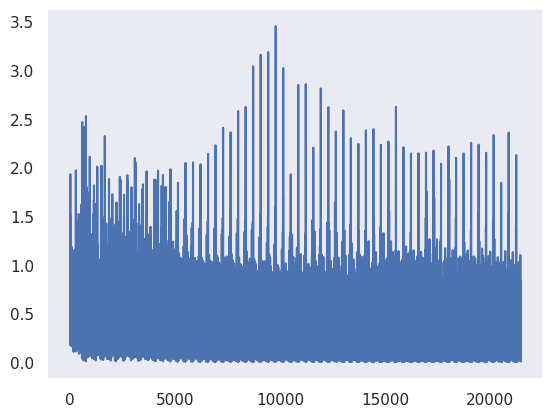

In [33]:
plt.plot(train_losses)

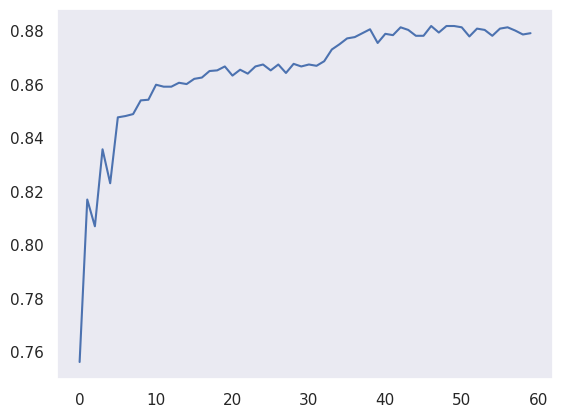

In [34]:
plt.plot(test_accuracy)

In [35]:
metrics2, confusion_matrix2 = report_metrics(model)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 3597/4064 (0.8851)
{'acc_detail': tensor([0.7423, 0.9299], device='cuda:0'),
 'acc_unweighted': tensor(0.8361, device='cuda:0'),
 'acc_weighted': tensor(0.8851, device='cuda:0'),
 'f1s': tensor(0.8400, device='cuda:0'),
 'f1s_detail': tensor([0.7551, 0.9249], device='cuda:0'),
 'precision_detail': tensor([0.7684, 0.9201], device='cuda:0'),
 'recall_detail': tensor([0.7423, 0.9299], device='cuda:0'),
 'rocauc': tensor([0.9401, 0.9401], device='cuda:0'),
 'uar': tensor(0.8361, device='cuda:0'),
 'wap': tensor(0.8839, device='cuda:0')}


tensor([[ 720,  250],
        [ 217, 2877]], device='cuda:0')

In [36]:
model_path = '../physio16k_fold4_m13_60epochs.pt' 
torch.save(model.state_dict(), model_path)

In [37]:
layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0036],
        [0.0075],
        [0.0117],
        [0.0162],
        [0.0211],
        [0.0264],
        [0.0322],
        [0.0384],
        [0.0451],
        [0.0524],
        [0.0603],
        [0.0688],
        [0.0780],
        [0.0880],
        [0.0988],
        [0.1105],
        [0.1231],
        [0.1368],
        [0.1516],
        [0.1676],
        [0.1849],
        [0.2036],
        [0.2239],
        [0.2458],
        [0.2696],
        [0.2952],
        [0.3230],
        [0.3531],
        [0.3855],
        [0.4208],
        [0.4588],
        [0.0000],
        [0.0054],
        [0.0111],
        [0.0171],
        [0.0235],
        [0.0303],
        [0.0375],
        [0.0452],
        [0.0534],
        [0.0620],
        [0.0712],
        [0.0809],
        [0.0912],
        [0.1022],
        [0.1138],
        [0.1261],
        [0.1392],
        [0.1531],
        [0.1679],
        [0.1835],
        [0.2002],
       

In [38]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [ 4.7259e-16],
        [ 8.1635e-16],
        [-1.3220e-15],
        [-5.4616e-17],
        [-1.5557e-16],
        [-1.9765e-17],
        [ 9.4759e-18],
        [ 2.6757e-16],
        [-4.2679e-16],
        [ 1.0412e-15],
        [ 3.9330e-15],
        [-2.4275e-16],
        [ 1.5019e-14],
        [-6.9089e-15],
        [-2.7159e-17],
        [ 9.5117e-16],
        [ 2.7424e-15],
        [ 1.4601e-18],
        [ 1.2300e-17],
        [-2.1315e-16],
        [ 1.3857e-15],
        [-1.8495e-15],
        [ 6.9214e-17],
        [ 5.8923e-17],
        [-1.8166e-15],
        [ 1.3873e-15],
        [ 3.0002e-15],
        [-1.8013e-16],
        [ 5.2139e-13],
        [-1.6660e-13],
        [ 1.6673e-17],
        [ 0.0000e+00],
        [-6.9911e-16],
        [-2.7845e-17],
        [-1.4502e-15],
        [ 1.4821e-12],
        [ 2.0240e-16],
        [ 4.6578e-17],
        [ 1.2907e-16],
        [-4.4976e-16],
        [ 9.0671e-16],
        [-3.6419e-16],
        [ 2

[None, None, None]

In [42]:
named_params = [p for p in layer.named_parameters()]
named_params

[('lowcut_bands',
  Parameter containing:
  tensor([[0.0000],
          [0.0036],
          [0.0075],
          [0.0117],
          [0.0162],
          [0.0211],
          [0.0264],
          [0.0322],
          [0.0384],
          [0.0451],
          [0.0524],
          [0.0603],
          [0.0688],
          [0.0780],
          [0.0880],
          [0.0988],
          [0.1105],
          [0.1231],
          [0.1368],
          [0.1516],
          [0.1676],
          [0.1849],
          [0.2036],
          [0.2239],
          [0.2458],
          [0.2696],
          [0.2952],
          [0.3230],
          [0.3531],
          [0.3855],
          [0.4208],
          [0.4588],
          [0.0000],
          [0.0054],
          [0.0111],
          [0.0171],
          [0.0235],
          [0.0303],
          [0.0375],
          [0.0452],
          [0.0534],
          [0.0620],
          [0.0712],
          [0.0809],
          [0.0912],
          [0.1022],
          [0.1138],
          [0.1261]

(array([  2.,   2.,   1.,   0.,   1.,   1.,   1.,   9., 112.,  11.,   3.,
          1.,   4.,   0.,   4.,   6.,   6.,  10.,   7.,   5.,   7.,   7.,
          7.,  11.,   8.,   6.,   5.,   4.,   3.,   0.,   1.,   1.,   0.,
          2.,   2.,   1.,   3.,   0.,   1.,   1.]),
 array([-0.57473284, -0.5065316 , -0.43833032, -0.37012905, -0.30192778,
        -0.23372653, -0.16552526, -0.097324  , -0.02912273,  0.03907853,
         0.10727979,  0.17548105,  0.24368232,  0.31188357,  0.38008484,
         0.44828612,  0.51648736,  0.58468866,  0.65288991,  0.72109115,
         0.78929245,  0.8574937 ,  0.92569494,  0.99389619,  1.06209743,
         1.13029873,  1.19850004,  1.26670122,  1.33490252,  1.40310383,
         1.47130501,  1.53950632,  1.60770762,  1.6759088 ,  1.74411011,
         1.81231141,  1.8805126 ,  1.9487139 ,  2.01691508,  2.08511639,
         2.15331769]),
 <BarContainer object of 40 artists>)

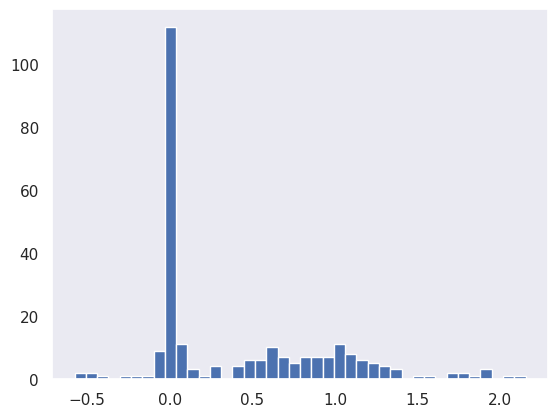

In [64]:
window_params = named_params[2][1].detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

(array([ 2.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,  1.,  2.,  5.,  6., 12.,
        20., 42., 66., 47., 26., 12.,  3.,  4.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([-0.04047657, -0.03784012, -0.03520366, -0.0325672 , -0.02993075,
        -0.02729429, -0.02465784, -0.02202138, -0.01938492, -0.01674847,
        -0.01411201, -0.01147556, -0.0088391 , -0.00620265, -0.00356619,
        -0.00092973,  0.00170672,  0.00434318,  0.00697963,  0.00961609,
         0.01225254,  0.014889  ,  0.01752546,  0.02016191,  0.02279837,
         0.02543482,  0.02807128,  0.03070774,  0.03334419,  0.03598065,
         0.0386171 ,  0.04125356,  0.04389001,  0.04652647,  0.04916293,
         0.05179938,  0.05443584,  0.05707229,  0.05970875,  0.06234521,
         0.06498166]),
 <BarContainer object of 40 artists>)

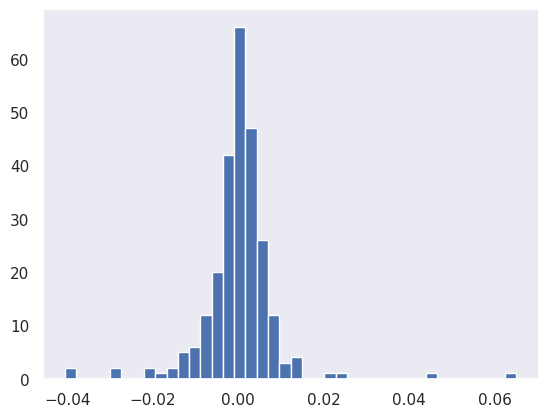

In [63]:
window_params = named_params[2][1].grad.detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

Time domain: Filters' shapes vary by frequency bins


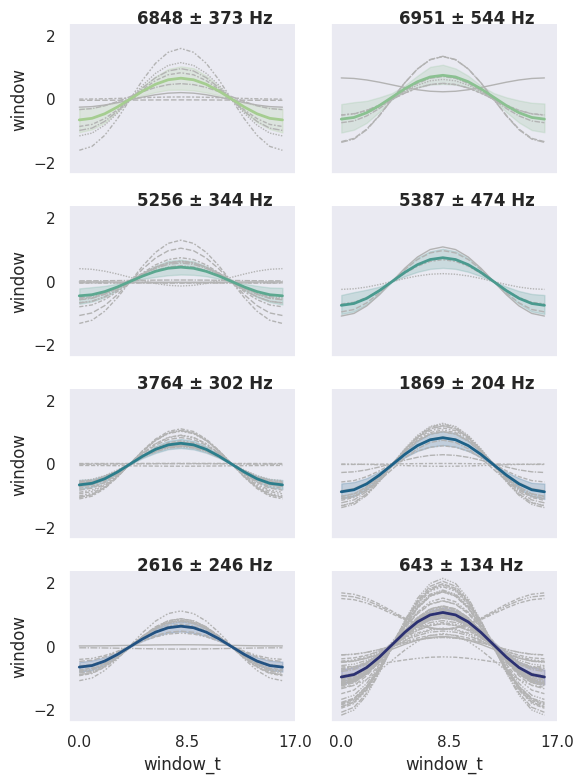

In [65]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


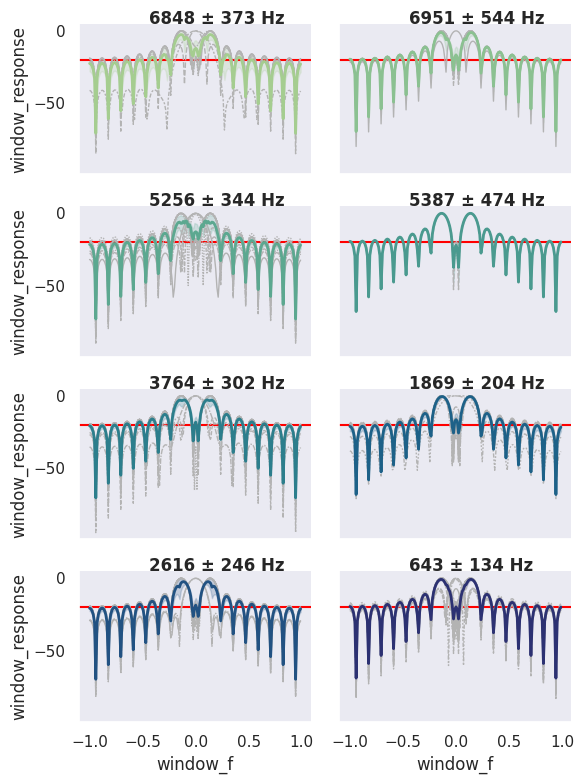

In [66]:
filtviz.visualize_filters(filter_domain='freq')

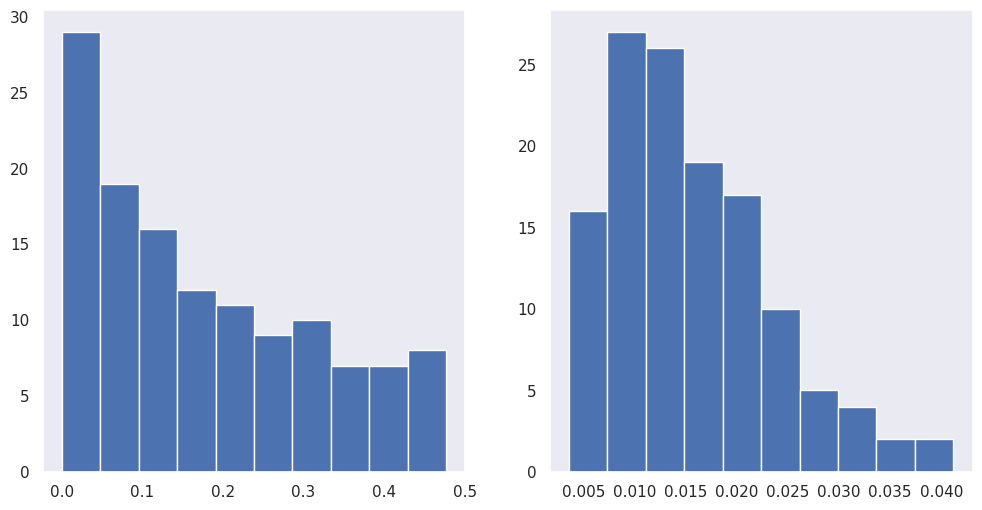

In [67]:
filtviz.visualize_bands()

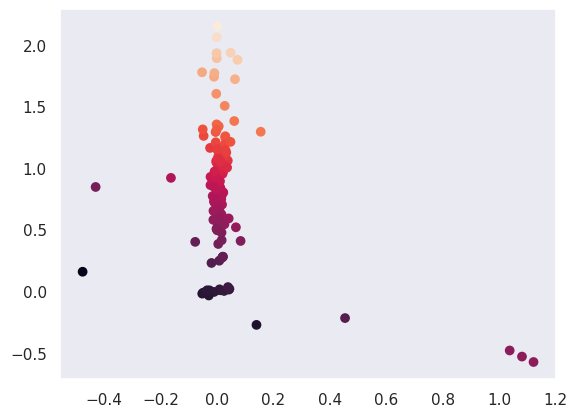

In [68]:
filtviz.visualize_window_params()

In [69]:
layer2 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer2)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0384, 0.0384, 0.0384,  ..., 0.0384, 0.0384, 0.0384],
        ...,
        [0.2594, 0.2594, 0.2594,  ..., 0.2594, 0.2594, 0.2594],
        [0.3309, 0.3309, 0.3309,  ..., 0.3309, 0.3309, 0.3309],
        [0.4108, 0.4108, 0.4108,  ..., 0.4108, 0.4108, 0.4108]],
       device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
        [0.0304, 0.0304, 0.0304,  ..., 0.0304, 0.0304, 0.0304],
        ...,
        [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
        [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
        [0.0892, 0.0892, 0.0892,  ..., 0.0892, 0.0892, 0.0892]],
       device='cuda:0', requires_grad=True))
('window_params', Parameter containing

In [70]:
named_params2 = [p for p in layer2.named_parameters()]
named_params2

[('lowcut_bands',
  Parameter containing:
  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
          [0.0384, 0.0384, 0.0384,  ..., 0.0384, 0.0384, 0.0384],
          ...,
          [0.2594, 0.2594, 0.2594,  ..., 0.2594, 0.2594, 0.2594],
          [0.3309, 0.3309, 0.3309,  ..., 0.3309, 0.3309, 0.3309],
          [0.4108, 0.4108, 0.4108,  ..., 0.4108, 0.4108, 0.4108]],
         device='cuda:0', requires_grad=True)),
 ('bandwidths',
  Parameter containing:
  tensor([[0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
          [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
          [0.0304, 0.0304, 0.0304,  ..., 0.0304, 0.0304, 0.0304],
          ...,
          [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
          [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
          [0.0892, 0.0892, 0.0892,  ..., 0.0892, 0.0892, 0.0892]],
         device='cuda:0', requires_grad=True))

(array([  2.,   2.,   1.,   0.,   1.,   1.,   1.,   9., 112.,  11.,   3.,
          1.,   4.,   0.,   4.,   6.,   6.,  10.,   7.,   5.,   7.,   7.,
          7.,  11.,   8.,   6.,   5.,   4.,   3.,   0.,   1.,   1.,   0.,
          2.,   2.,   1.,   3.,   0.,   1.,   1.]),
 array([-0.57473284, -0.5065316 , -0.43833032, -0.37012905, -0.30192778,
        -0.23372653, -0.16552526, -0.097324  , -0.02912273,  0.03907853,
         0.10727979,  0.17548105,  0.24368232,  0.31188357,  0.38008484,
         0.44828612,  0.51648736,  0.58468866,  0.65288991,  0.72109115,
         0.78929245,  0.8574937 ,  0.92569494,  0.99389619,  1.06209743,
         1.13029873,  1.19850004,  1.26670122,  1.33490252,  1.40310383,
         1.47130501,  1.53950632,  1.60770762,  1.6759088 ,  1.74411011,
         1.81231141,  1.8805126 ,  1.9487139 ,  2.01691508,  2.08511639,
         2.15331769]),
 <BarContainer object of 40 artists>)

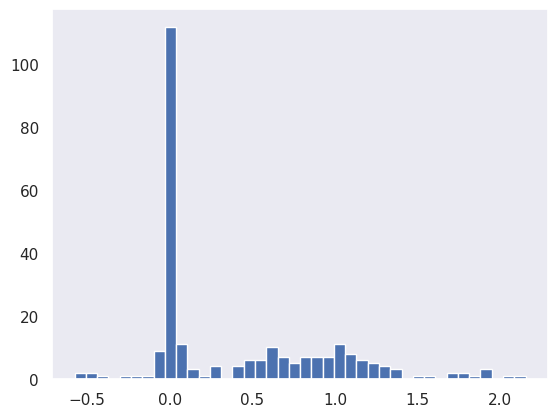

In [71]:
window_params2 = named_params[2][1].detach().cpu().numpy()
plt.hist(window_params2.flatten(), bins=40)

(array([ 2.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,  1.,  2.,  5.,  6., 12.,
        20., 42., 66., 47., 26., 12.,  3.,  4.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([-0.04047657, -0.03784012, -0.03520366, -0.0325672 , -0.02993075,
        -0.02729429, -0.02465784, -0.02202138, -0.01938492, -0.01674847,
        -0.01411201, -0.01147556, -0.0088391 , -0.00620265, -0.00356619,
        -0.00092973,  0.00170672,  0.00434318,  0.00697963,  0.00961609,
         0.01225254,  0.014889  ,  0.01752546,  0.02016191,  0.02279837,
         0.02543482,  0.02807128,  0.03070774,  0.03334419,  0.03598065,
         0.0386171 ,  0.04125356,  0.04389001,  0.04652647,  0.04916293,
         0.05179938,  0.05443584,  0.05707229,  0.05970875,  0.06234521,
         0.06498166]),
 <BarContainer object of 40 artists>)

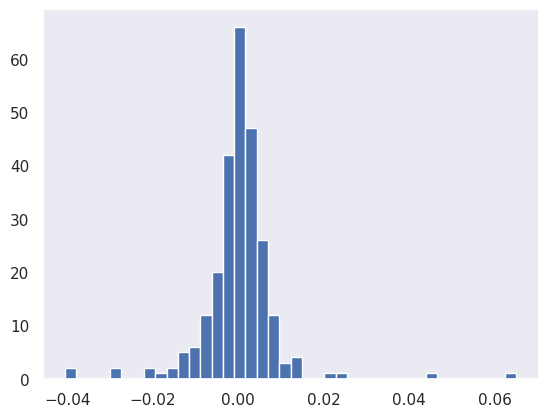

In [72]:
window_params2 = named_params[2][1].grad.detach().cpu().numpy()
plt.hist(window_params2.flatten(), bins=40)

downsample_factor: 8 => new_sample_rate: 2000
Time domain: Filters' shapes vary by frequency bins


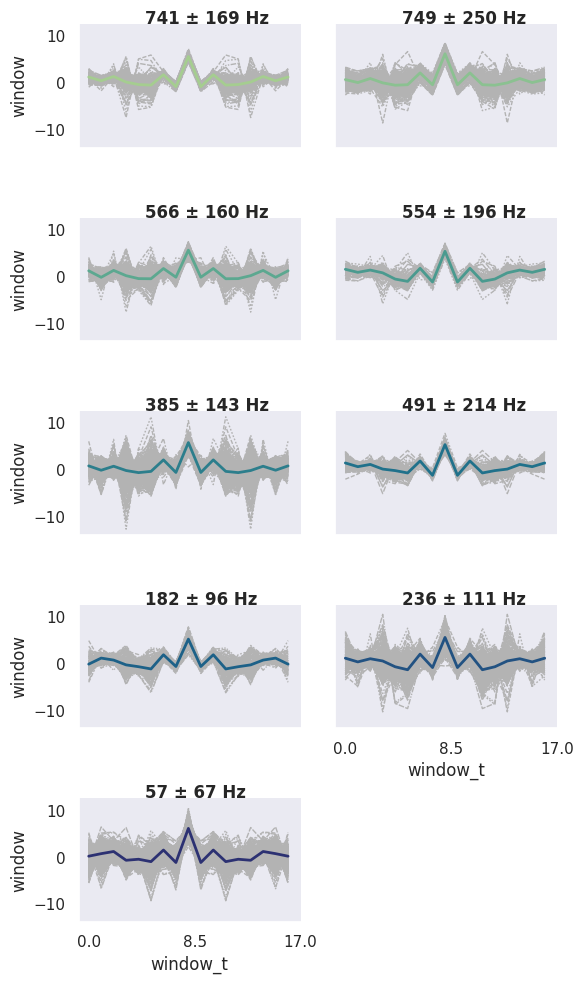

In [73]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


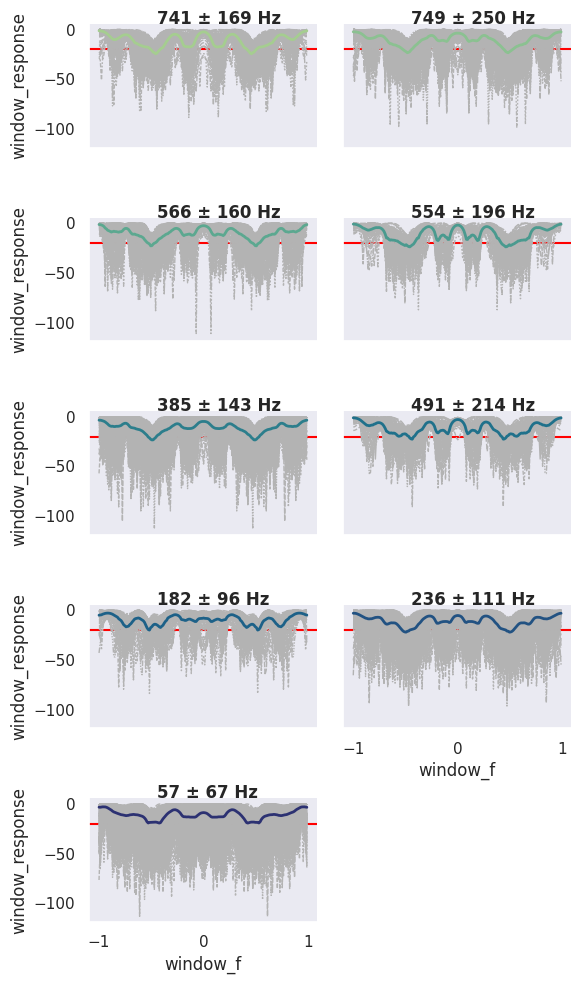

In [74]:
filtviz2.visualize_filters(filter_domain='freq')

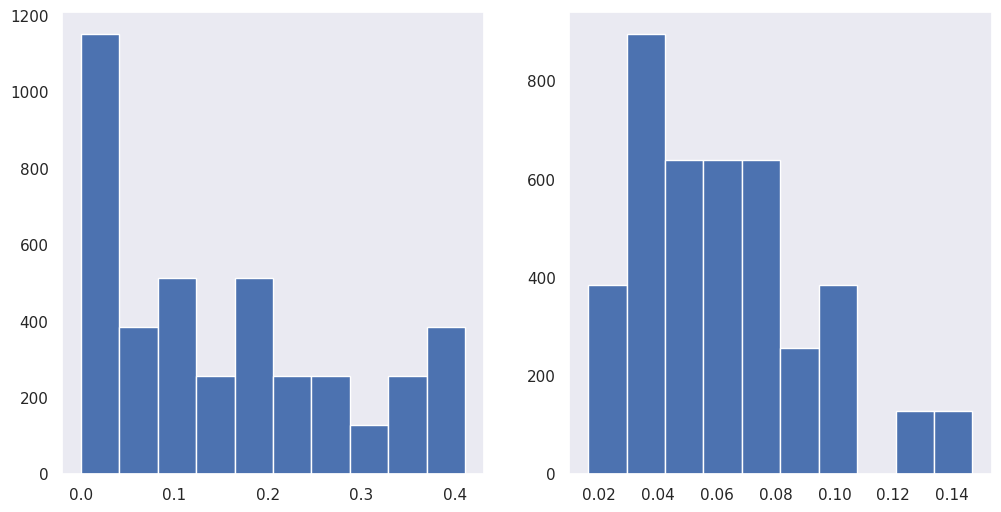

In [75]:
filtviz2.visualize_bands()

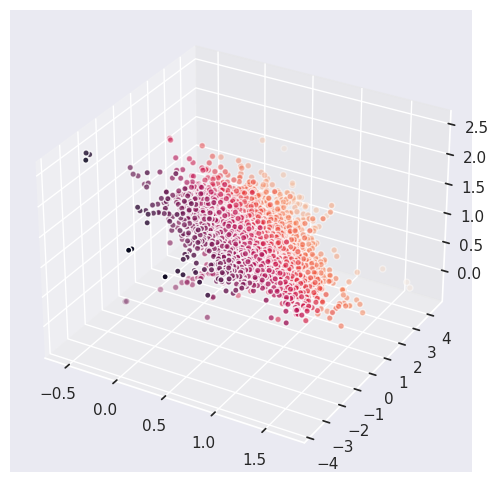

In [76]:
filtviz2.visualize_window_params()

In [77]:
# del model
# gc.collect()

340729